### **Overview of the project:**

* Import training dataset
* Create new relevant features with available data
> Features will be later filtered based on its impact on the model
* Anomaly detection and removal using PCA transformation
* Visualize features seperately for each turbine
> timestamp in training data will only be used for visualization and no features will be extracted from it
* Clustering based on climate/weather features to segregate data into two clusters (most likely hot and cold seasons)
* Data transformation:
  * Skewness correction
  * Concatenation of different turbines data into single df
  * Remove outlier based on visualization wrt target column
  * OHE for turbine_id
* Finalize features based on impact on the model and also remove high correlated columns
* Split data into train-test with stratification on turbine_ids (train-test should have proportioned data of each turbine)
* Construct Tensorflow sequential neural network
* Define learning rate schedule, optimizer and loss function
* Model training
  > **current MAPE on complete data: ~0.00925**
  
  > **time: 7 hrs**
  
  > **MachineHack public score: 0.01042**   
* Plot losses and metrics wrt. epochs
* Save model
* Load model
* Submission:
  * Repeat same transformations on the test df
  * Prediction from the loaded model
  * Save the submission file 
  * Check the predicted data
* Inferences / Improvement prospects 

# Importing training data into Pandas df

In [ ]:
import pandas as pd

In [ ]:
# To display all column:
pd.set_option('display.max_columns', None)

# To supress warnings during the run:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv("../input/renew-power-hackathon-data/train.csv")                       # Provide the train.csv file directory

df['timestamp'] = df['timestamp'].astype('datetime64')

df.head()

,timestamp,active_power_calculated_by_converter,active_power_raw,ambient_temperature,generator_speed,generator_winding_temp_max,grid_power10min_average,nc1_inside_temp,nacelle_temp,reactice_power_calculated_by_converter,reactive_power,wind_direction_raw,wind_speed_raw,wind_speed_turbulence,turbine_id,Target
0,2021-02-19 20:18:00,816.636759,834.917206,31.694380,1159.616602,65.954214,917.897085,31.881972,31.504713,141.457644,165.501518,280.864782,7.057000,0.544082,Turbine_108,47.582787
1,2021-04-27 04:55:00,419.107829,421.050873,12.894948,928.747996,59.571319,445.554250,32.423705,32.755770,89.186457,113.835236,299.552460,5.474937,0.469031,Turbine_18,46.070328
2,2021-01-25 06:26:00,1303.530558,1337.566142,16.648388,1201.219775,61.270498,1364.716003,11.446849,18.332985,230.622309,281.452253,84.960106,8.092457,0.622318,Turbine_105,39.989236
3,2021-10-30 03:47:00,61.494872,53.481008,28.388141,769.806122,40.674348,14.324897,34.253204,32.662889,66.211015,75.017531,87.261119,4.071032,0.760719,Turbine_15,46.056587
4,2021-03-15 00:39:00,593.514364,611.659108,31.519527,1046.916768,64.341763,599.020172,32.405586,31.466387,137.163938,160.202421,313.724818,6.357943,0.346068,Turbine_01,54.346095


# EDA

In [ ]:
df.shape

(909604, 16)

In [ ]:
# Checking null values

df.isna().sum()

timestamp                                 0
active_power_calculated_by_converter      0
active_power_raw                          0
ambient_temperature                       0
generator_speed                           0
generator_winding_temp_max                0
grid_power10min_average                   0
nc1_inside_temp                           0
nacelle_temp                              0
reactice_power_calculated_by_converter    0
reactive_power                            0
wind_direction_raw                        0
wind_speed_raw                            0
wind_speed_turbulence                     0
turbine_id                                0
Target                                    0
dtype: int64

## Creating new features

> Not all the features will be used in modelling. Many will be filtered in the later stage

In [ ]:
# # Converting temp from C to K:

# df['ambient_temperature'] = df['ambient_temperature'] + 273
# df['nc1_inside_temp'] = df['nc1_inside_temp'] + 273
# df['nacelle_temp'] = df['nacelle_temp'] + 273

# Powers:

df['apparent_power'] = (df['active_power_raw']**2 + df['reactive_power']**2)**0.5
# df['power_factor'] = df['active_power_raw']/df['apparent_power']

df['apparent_power_by_converter'] = (df['active_power_calculated_by_converter']**2 + df['reactice_power_calculated_by_converter']**2)**0.5
# df['power_factor_by_converter'] = df['active_power_calculated_by_converter']/df['apparent_power_by_converter']

df['power_diff'] =  df['grid_power10min_average'] - df['apparent_power_by_converter']

# df['power_sum'] = df['active_power_raw'] + df['reactive_power']
# df['power_sum_by_converter'] = df['active_power_calculated_by_converter'] + df['reactice_power_calculated_by_converter']

df['power_frm_wind_speed'] = (df['wind_speed_raw']**3)/df['ambient_temperature']                       #Generate power directly proportional to v**3

# Wind speed:

df['wind_speed_frm_raw_power'] = (df['ambient_temperature'] * df['active_power_raw'])**(1/3)
df['wind_speed_frm_apparent_power'] = (df['ambient_temperature'] * df['apparent_power'])**(1/3)
df['wind_speed_frm_avg_power'] = (df['ambient_temperature'] * df['grid_power10min_average'])**(1/3)

# df['wind_speed_frm_power_sum'] = (df['ambient_temperature'] * df['power_sum'])**(1/3)
# df['wind_speed_frm_power_sum_by_converter'] = (df['ambient_temperature'] * df['power_sum_by_converter'])**(1/3)

import numpy as np

df['cos_wind_direction'] = np.cos(np.radians(df['wind_direction_raw']))
df['wind_velocity'] = df['wind_speed_raw'] * df['cos_wind_direction']

df['resultant_wind_speed'] = (df['wind_speed_raw']**2 + df['wind_speed_turbulence']**2)**0.5
df['resultant_wind_velocity'] = df['resultant_wind_speed'] * df['cos_wind_direction']

df['frictional_factor'] = df['generator_speed']**2                                                     #Frictional force directly proportional to omega**2

df['diff_active_power'] = df['active_power_raw'] - df['active_power_calculated_by_converter']         #Difference btw. input & output of convertor
df['diff_reactive_power'] = df['reactive_power'] - df['reactice_power_calculated_by_converter']       #Difference btw. input & output of convertor
df['diff_nacelle_temp'] = df['nc1_inside_temp'] - df['nacelle_temp']                                  #Difference between inside and outside nacelle temp

# Phase angle between active and reactive power:

df['phase_angle'] = np.arctan(df['reactive_power']/df['active_power_raw'])
# df['phase_angle_by_converter'] = np.arctan(df['reactice_power_calculated_by_converter']/df['active_power_calculated_by_converter'])

## Visualization

### Making groups of turbine and sorting as per timestamp

---
> **timestamp will only be used for visualization in EDA and will be dropped before modelling**
---

In [ ]:
dict_turbine_x = {}
dict_turbine_y = {}
# dict_scaler = {}

for turbine_id, data in df.groupby('turbine_id'):
    data = data.sort_values(by = 'timestamp', ascending = True)
    data = data.set_index('timestamp', drop = True)
    data = data.drop(['turbine_id'], axis =1)
    
    dict_turbine_y[turbine_id] = data['Target']
    dict_turbine_x[turbine_id] = data.drop('Target', axis = 1)

In [ ]:
# Uncomment below code to remove extreme values based on z score after scaling:
    
# for key in dict_turbine_x.keys():
#     from sklearn.preprocessing import MinMaxScaler, RobustScaler, PowerTransformer, StandardScaler

#     dict_scaler[key] = StandardScaler()
#     dict_turbine_x[key] = pd.DataFrame(dict_scaler[key].fit_transform(dict_turbine_x[key]), columns = dict_turbine_x[key].columns, index = dict_turbine_x[key].index)
    
# for key in dict_turbine_x.keys():
#     from scipy import stats
#     import numpy as np
    
#     data = pd.concat([dict_turbine_x[key], dict_turbine_y[key]], axis = 1)
#     data = data.dropna()
#     data = data[(np.abs(stats.zscore(data)) < 3.5).all(axis = 1)]
    
#     dict_turbine_y[key] = data['Target']
#     dict_turbine_x[key] = data.drop('Target', axis = 1)

In [ ]:
# All turbine's name as keys:

dict_turbine_x.keys()

dict_keys(['Turbine_01', 'Turbine_10', 'Turbine_103', 'Turbine_105', 'Turbine_108', 'Turbine_120', 'Turbine_123', 'Turbine_13', 'Turbine_139', 'Turbine_14', 'Turbine_15', 'Turbine_158', 'Turbine_18', 'Turbine_19', 'Turbine_20', 'Turbine_97'])

In [ ]:
# Anomaly detection using PCA transformation then reconstruction;
# Can be used to eliminate extreme/random values from the sensors:

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import PowerTransformer

def get_anomaly_scores(df_original, df_restored):
        loss = np.sum((np.array(df_original) - np.array(df_restored)) ** 2, axis=1)
        loss = pd.Series(data=loss, index=df_original.index)
        return loss

for key in dict_turbine_x.keys():
    df2 = dict_turbine_x[key]
    
    scaler = PowerTransformer()
    df2 = pd.DataFrame(scaler.fit_transform(df2), columns = df2.columns, index = df2.index)
    
    pca = PCA(n_components = df2.shape[1], random_state = 6)
    df_pca = pd.DataFrame(pca.fit_transform(df2), index=df2.index)
    df_restored = pd.DataFrame(pca.inverse_transform(df_pca), index = df_pca.index)

    dict_turbine_x[key]['reconstruction_error'] = get_anomaly_scores(df2, df_restored)


# To remove data with extreme pca_reconstruction_error:

for key in dict_turbine_x.keys():
    from scipy import stats
    import numpy as np
    
    data = pd.concat([dict_turbine_x[key], dict_turbine_y[key]], axis = 1)
    data = data[(np.abs(stats.zscore(data['reconstruction_error'])) < 3.5)]
    
    dict_turbine_y[key] = data['Target']
    dict_turbine_x[key] = data.drop(['reconstruction_error', 'Target'], axis = 1)

### Visualizing target and other features yearly trend for different turbine:

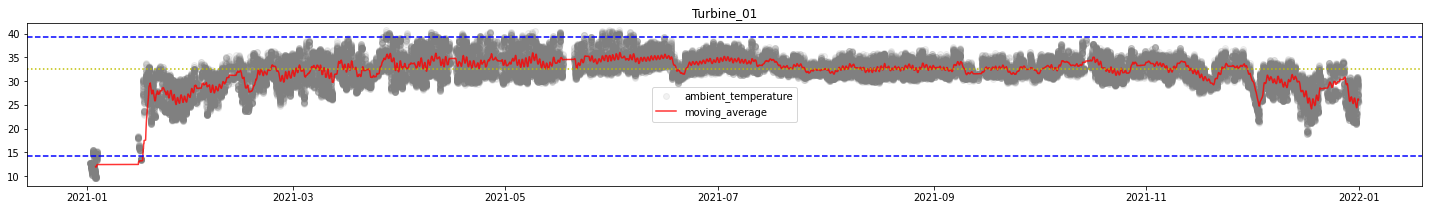

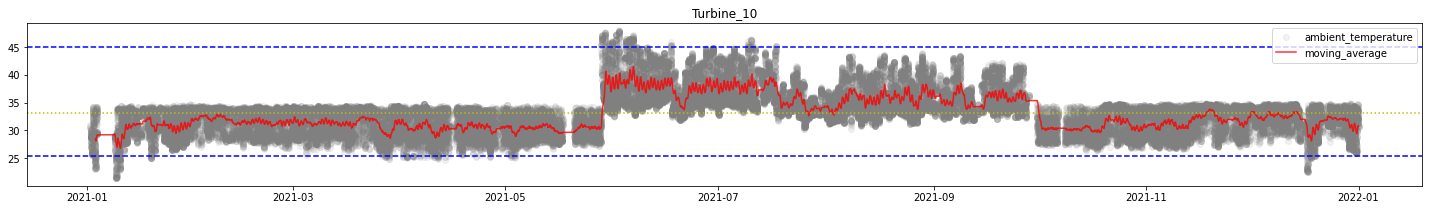

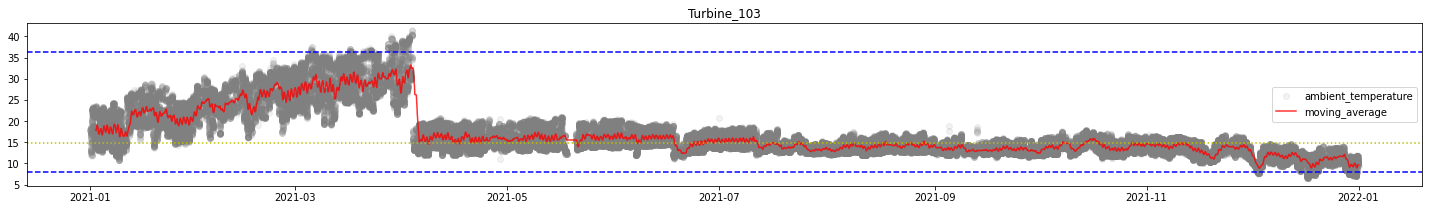

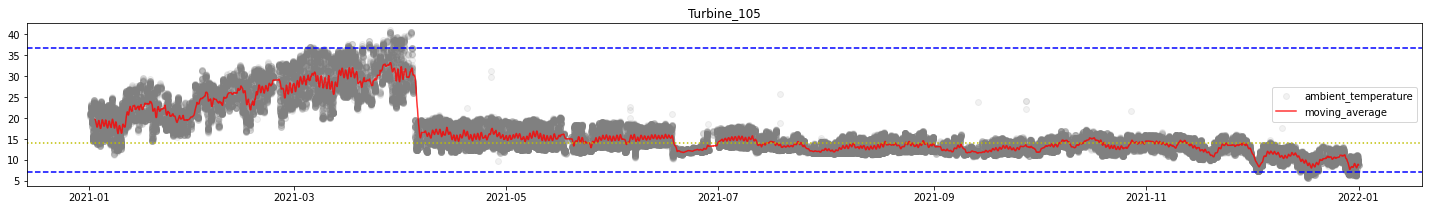

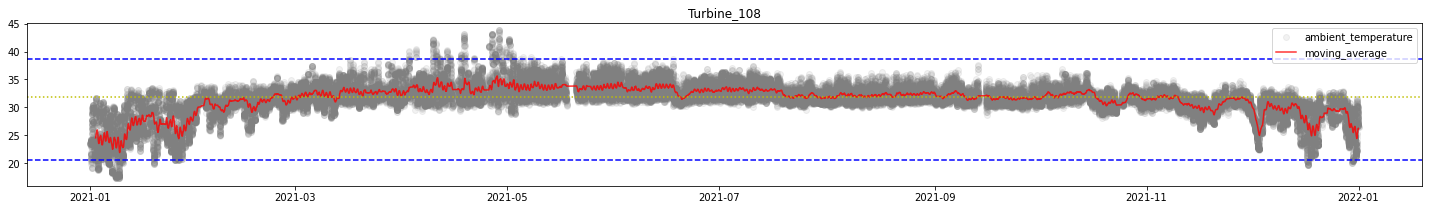

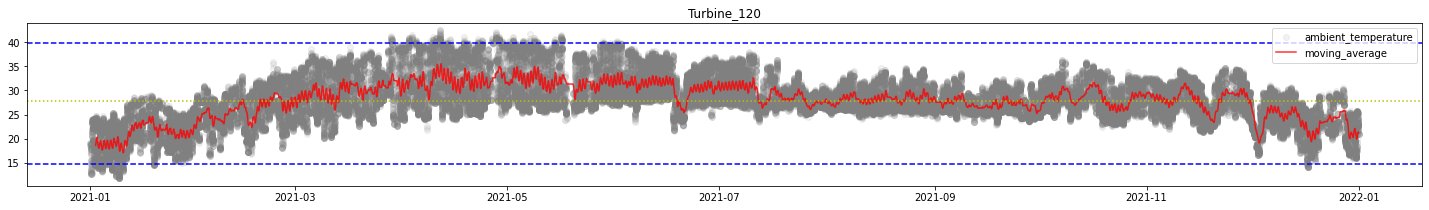

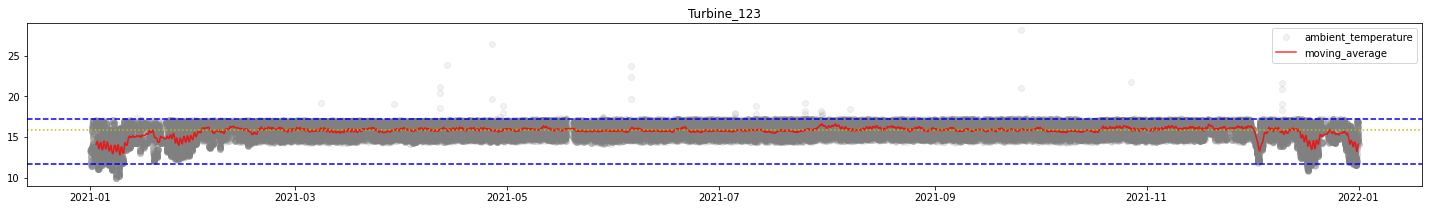

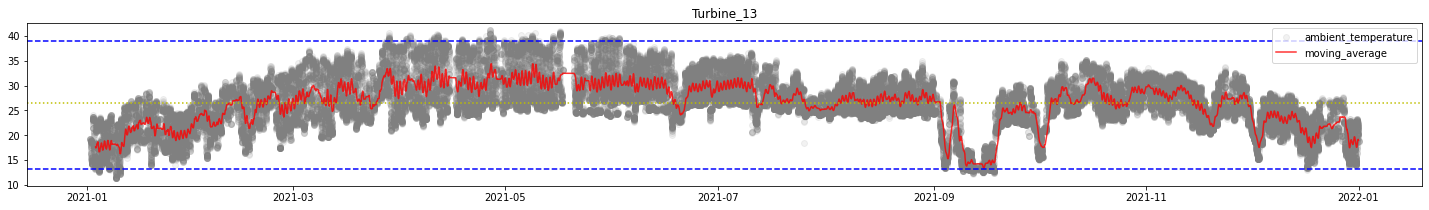

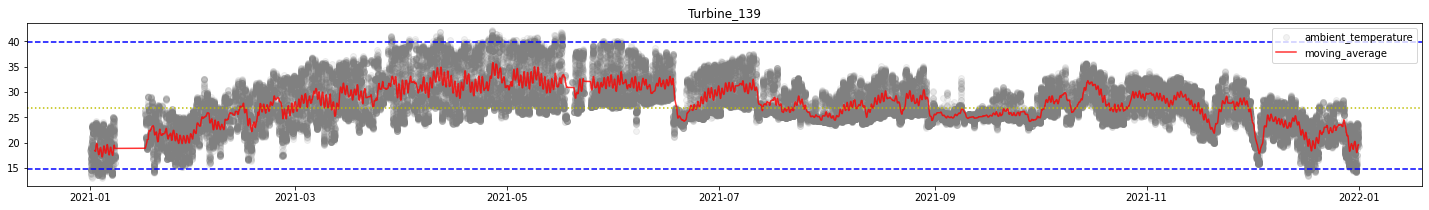

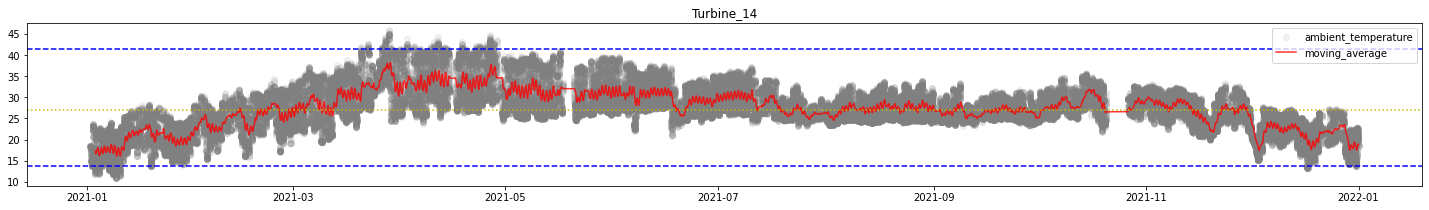

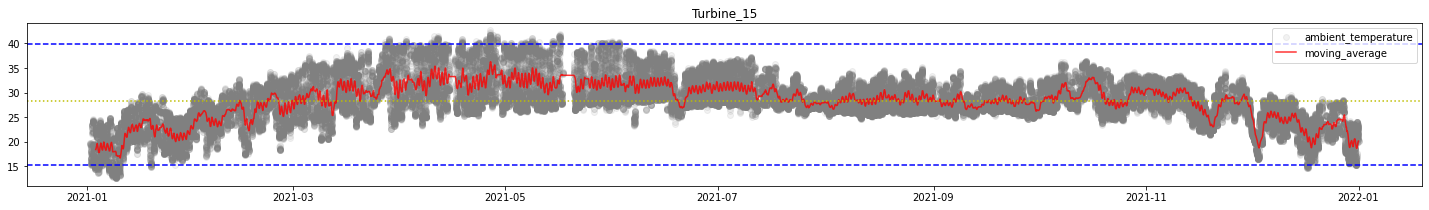

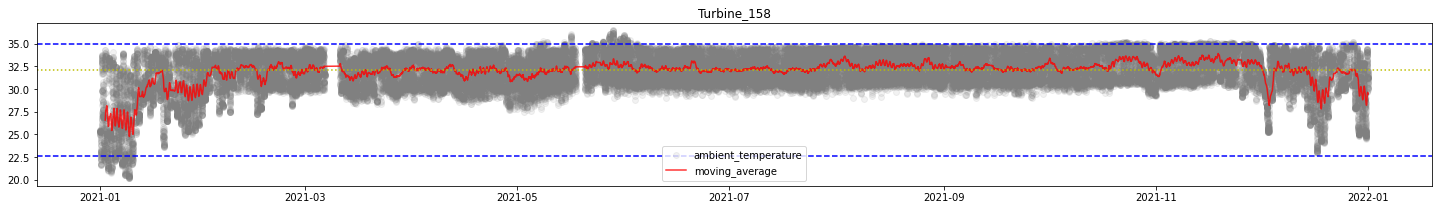

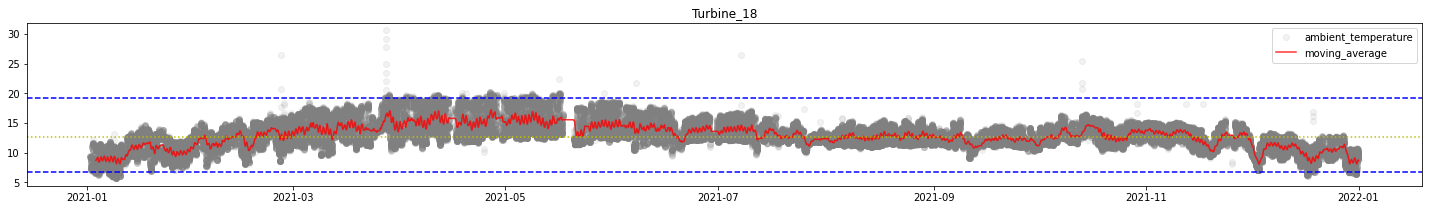

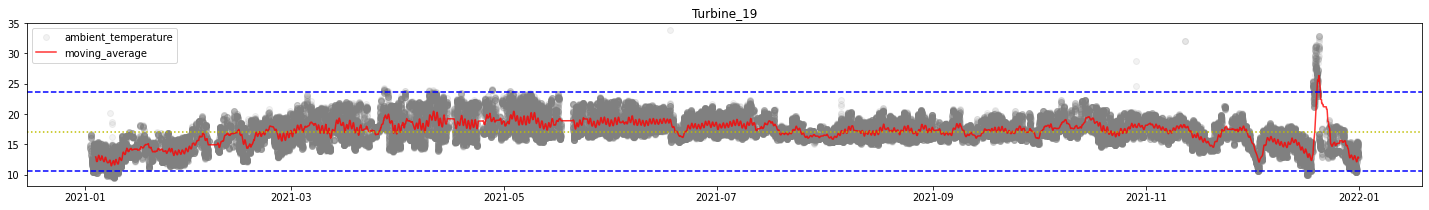

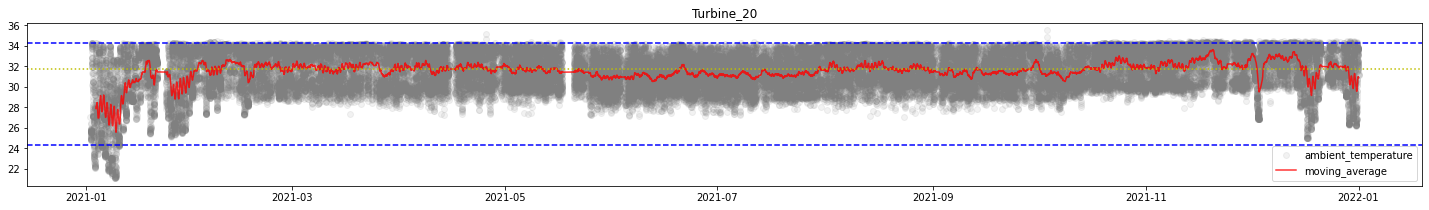

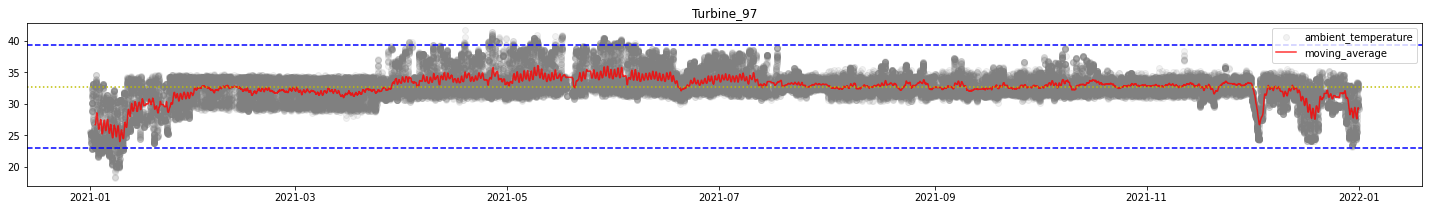

In [ ]:
for key in dict_turbine_x.keys():
    df2_x = dict_turbine_x[key]
    df2_y = dict_turbine_y[key]

    import matplotlib.pyplot as plt

    fig, ax1 = plt.subplots(figsize = (25, 3))
    
    y = 'ambient_temperature'                             #Replace y with any feature to visualize

#     ax2 = ax1.twinx()
#     ax3 = ax1.twinx()

    ax1.scatter( df2_x.index, df2_x[y][:], label = y, color = 'grey', alpha = 0.1)
    ax1.plot( df2_x.index, df2_x[y].rolling(250).mean(), label = 'moving_average', color = 'red', alpha = 0.8)

    ax1.axhline(y = df2_x[y].quantile(q = 0.50), color = 'y', linestyle = ':')
    ax1.axhline(y = df2_x[y].quantile(q = 0.005), color = 'b', linestyle = '--')
    ax1.axhline(y = df2_x[y].quantile(q = 0.995), color = 'b', linestyle = '--')
    
    ax1.title.set_text(key)
    ax1.legend()

plt.show()

### **Notes:**
> Turbine behaves differently and scalling all as same data will undermine values from turbine with smaller values.
Scale each turbine independently and then concatenate all together

> From the yearly trend it looks like many features depends on season/weather (different values in different months). **As timestamp can't be used to extract months, we will use clusterring to seperate these different data points** 

## Clustering

In [ ]:
!pip install hdbscan

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 3.5 MB/s eta 0:00:0000:0100:010m
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for hdbscan: filename=hdbscan-0.8.28-cp37-cp37m-linux_x86_64.whl size=3425782 sha256=401a28756a0b93a5a8f8c8efe65669a6a377d2587dbeddba799d1d82c0e187cf
  Stored in directory: /root/.cache/pip/wheels/6e/7a/5e/259ccc841c085fc41b99ef4a71e896b62f5161f2bc8a14c97a
Successfully built hdbscan


In [ ]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from cuml.manifold import TSNE
from sklearn.cluster import KMeans
from hdbscan import flat
import matplotlib.pyplot as plt

dict_scaler_minmax = {}
dict_kmean = {}
dict_hbds = {}

for key in dict_turbine_x.keys():
    
#     Select features to be used for clustering:
    df2 = dict_turbine_x[key]
    df2 = df2[['ambient_temperature', 'wind_direction_raw', 'wind_speed_turbulence', 'wind_speed_raw']]
    
#     Scaling before clustering:
    dict_scaler_minmax[key] = MinMaxScaler()
    df2 = pd.DataFrame(dict_scaler_minmax[key].fit_transform(df2), columns = df2.columns, index = df2.index)
    
#     KMean clusttering:
    dict_kmean[key] = KMeans(n_clusters = 2, n_init = 25, max_iter = 600, tol = 5e-3)
    dict_kmean[key].fit(df2)
    pred_km = dict_kmean[key].labels_
    
#     HBDSCAN clusterring:
    try:
        dict_hbds[key] = flat.HDBSCAN_flat(df2, n_clusters = 2, cluster_selection_method = 'eom',
                                           min_cluster_size = 2000, min_samples = 6,
                                           allow_single_cluster = False,
                                           prediction_data = True)
        pred_hbds = dict_hbds[key].labels_
    except:
        print('HDBSCAN failed for -->', key)
#         If HDBSCAN fails to form two clusters then use Kmean
        pred_hbds = pred_km
    
#     Save labels:
    dict_turbine_x[key]['hdbscan'] = pred_hbds
    dict_turbine_x[key]['kmean'] = pred_km
    
# #     Uncomment below to visualize clusttering:
    
# #     t-SNE plot:
#     tsne = TSNE(random_state = 6, 
#                 n_components = 2, perplexity = 30, 
#                 early_exaggeration = 25, late_exaggeration = 15, 
#                 learning_rate = 50, n_iter = 2000, 
#                 method = 'barnes_hut', exaggeration_iter = 250)
#     df_tsne = tsne.fit_transform(df2)
    
# #     Extracting months from timestamp to validate clusterring (Note: months will not be used, it is just for comparision):
#     months = pd.Series(df2.index).dt.month
#     bins = [0, 3, 8, 12]
#     labels = [0, 1, 2]
#     seasons = pd.cut(months, bins = bins, labels = labels, ordered = False)
    
# #     Plotting Clusttering results:
#     fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (20, 5))
#     fig.suptitle(key)
    
#     ax1.scatter(df_tsne[:,0], df_tsne[:,1], c = seasons, s = 0.5, label = 't-SNE')
#     ax2.scatter(df_tsne[:,0], df_tsne[:,1], c = pred_km, s = 0.5, label = 'Kmean')
#     ax3.scatter(df_tsne[:,0], df_tsne[:,1], c = pred_hbds, s = 0.5, label = 'HBDSCAN')
    
#     ax1.legend()
#     ax2.legend()
#     ax3.legend()
    
#     plt.show()

HDBSCAN failed for --> Turbine_108
HDBSCAN failed for --> Turbine_20


In [ ]:
# To set label 1 for hot season and label 0 for other seasons: 

for key in dict_turbine_x.keys():
    if dict_turbine_x[key].groupby(['hdbscan'])['ambient_temperature'].agg(mean = 'mean')[-2:].sort_values(by = 'mean').index[0] == 1:
        dict_turbine_x[key]['hdbscan'] = np.where(dict_turbine_x[key]['hdbscan'] == -1, dict_turbine_x[key]['hdbscan'], 1 - dict_turbine_x[key]['hdbscan'])

# To impute the noise labels (-1) in hdbscan with kmean labels: 

for key in dict_turbine_x.keys():
    
    m = dict_turbine_x[key].groupby(['hdbscan'])['ambient_temperature'].agg(mean = 'mean')[-2:].sort_values(by = 'mean').index
    n = dict_turbine_x[key].groupby(['kmean'])['ambient_temperature'].agg(mean = 'mean').sort_values(by = 'mean').index
    
    if sum(m*n) == 0:
        dict_turbine_x[key]['kmean'] = 1 - dict_turbine_x[key]['kmean']
        
    dict_turbine_x[key]['hdbscan'] = np.where(dict_turbine_x[key]['hdbscan'] == -1, dict_turbine_x[key]['kmean'], dict_turbine_x[key]['hdbscan'])
    
# To have two OHE columns for both labels:

for key in dict_turbine_x.keys():
    dict_turbine_x[key]['kmean_2'] = 1 - dict_turbine_x[key]['kmean']
    dict_turbine_x[key]['hdbscan_2'] = 1 - dict_turbine_x[key]['hdbscan']

## Transformations

In [ ]:
# Correcting skewness of the features:

from sklearn.preprocessing import MinMaxScaler, RobustScaler, PowerTransformer, StandardScaler

dict_scaler_powertrans = {}

for key in dict_turbine_x.keys():
    columns = list(dict_turbine_x[key].columns)[:-4]

    dict_scaler_powertrans[key] = PowerTransformer()
    dict_turbine_x[key][columns] = pd.DataFrame(dict_scaler_powertrans[key].fit_transform(dict_turbine_x[key][columns]), columns = columns, index = dict_turbine_x[key].index)

In [ ]:
# Concatenating all into single df:

df = pd.DataFrame()
for key in dict_turbine_x.keys():
    dict_turbine_x[key]['turbine_id'] = key
    dict_turbine_x[key] = pd.concat([dict_turbine_x[key], dict_turbine_y[key]], axis = 1)
    df = pd.concat([df, dict_turbine_x[key]], axis = 0)

In [ ]:
# Check for null values:

print(df.isna().sum())

# Dropping null values:

df = df.dropna()

active_power_calculated_by_converter      0
active_power_raw                          0
ambient_temperature                       0
generator_speed                           0
generator_winding_temp_max                0
grid_power10min_average                   0
nc1_inside_temp                           0
nacelle_temp                              0
reactice_power_calculated_by_converter    0
reactive_power                            0
wind_direction_raw                        0
wind_speed_raw                            0
wind_speed_turbulence                     0
apparent_power                            0
apparent_power_by_converter               0
power_diff                                0
power_frm_wind_speed                      0
wind_speed_frm_raw_power                  0
wind_speed_frm_apparent_power             0
wind_speed_frm_avg_power                  0
cos_wind_direction                        0
wind_velocity                             0
resultant_wind_speed            

<AxesSubplot:ylabel='Frequency'>

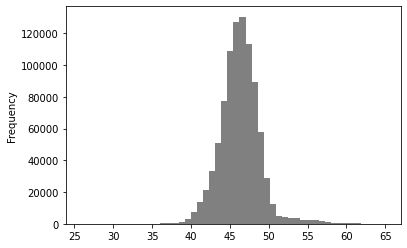

In [ ]:
# Visualize 'Target' column:

df['Target'].plot(kind = 'hist', color = 'grey', bins = 50)

In [ ]:
df['Target'].skew()

0.7091937289649323

In [ ]:
len(df[(df['Target'] < 30) | (df['Target'] > 60)])

1121

In [ ]:
# Remove extreme values with less samples:

# df = df[(df['Target'] > 35) & (df['Target'] < 60)]

In [ ]:
# Defining numerical columns for visualization:

num_columns = [column for column in df.columns if column != 'turbine_id']
len(num_columns)

34

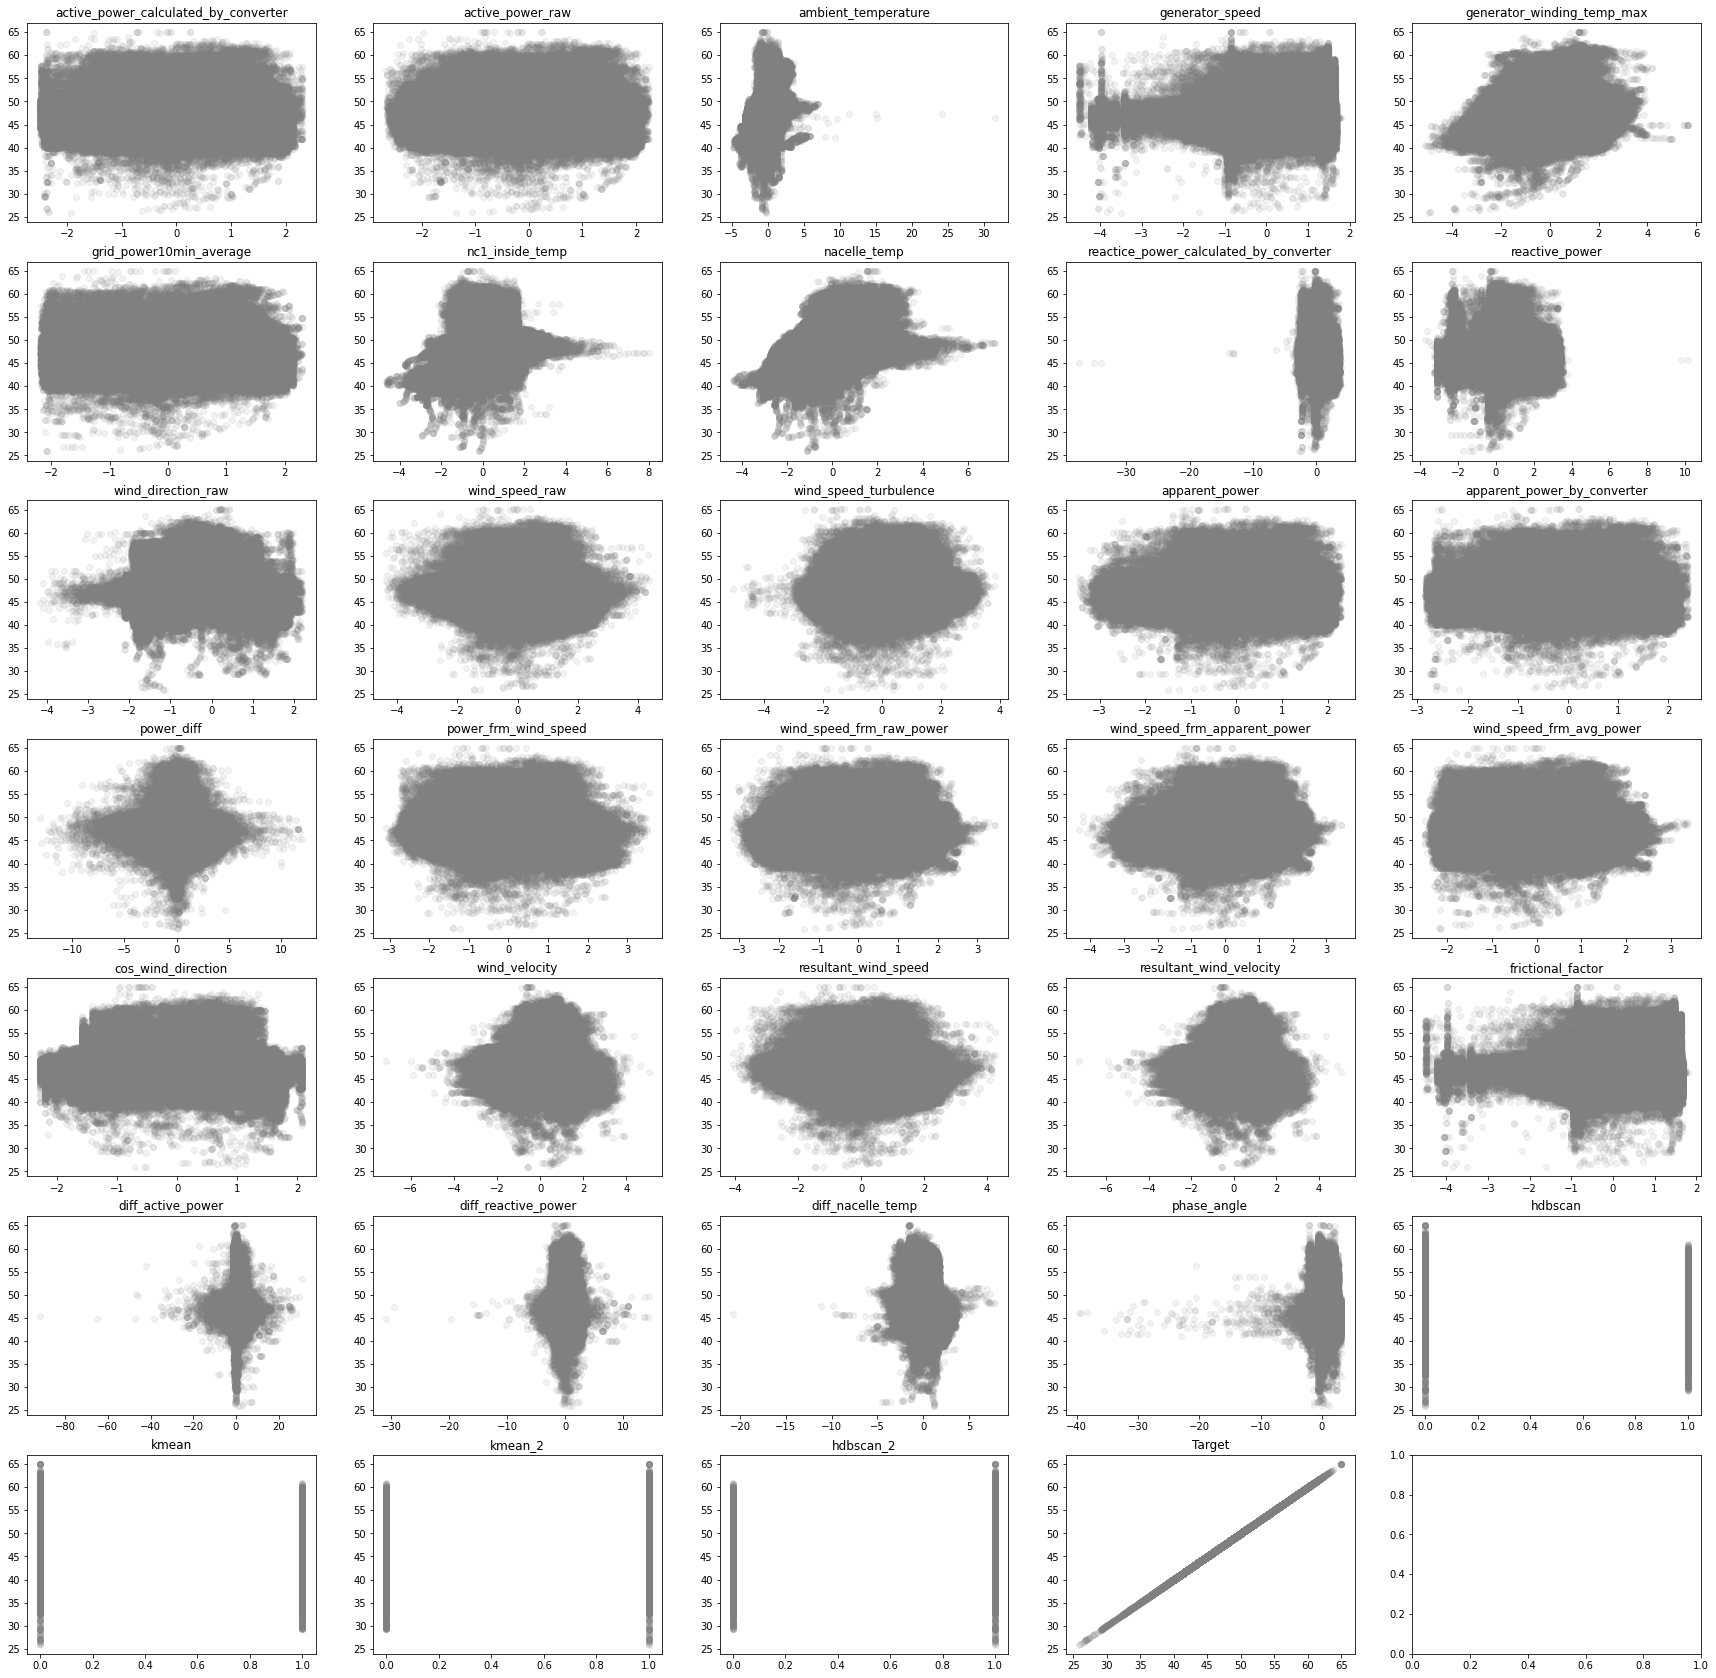

In [ ]:
# Plot features wrt. target:

fig, axes = plt.subplots(7,5 , figsize = (30, 30))
axes = axes.flat

for ax, column in zip(axes, num_columns):
    ax.scatter(x = df[column], y = df['Target'], color = 'grey', alpha = 0.1)
    ax.title.set_text(column)

plt.show()

In [ ]:
# Remove outliers from the above graphs:

print(len(df[df['ambient_temperature'] > 10]))
df = df[~(df['ambient_temperature'] > 10)]

# print(len(df[df['generator_winding_temp_max'] > 5]))
# df = df[~(df['generator_winding_temp_max'] > 5)]

# print(len(df[df['reactive_power'] > 10]))
# df = df[~(df['reactive_power'] > 10)]

# print(len(df[(df['nc1_inside_temp'] > 3.75) | (df['nc1_inside_temp'] < -6)]))
# df = df[~((df['nc1_inside_temp'] > 3.75) | (df['nc1_inside_temp'] < -6))]

print(len(df[(df['reactice_power_calculated_by_converter'] > 10) | (df['reactice_power_calculated_by_converter'] < -10)]))
df = df[~((df['reactice_power_calculated_by_converter'] > 10) | (df['reactice_power_calculated_by_converter'] < -10))]

print(len(df[df['reactive_power'] > 4]))
df = df[~(df['reactive_power'] > 4)]

# print(len(df[df['power_frm_wind_speed'] > 25]))
# df = df[~(df['power_frm_wind_speed'] > 25)]

# print(len(df[(df['wind_velocity'] > 4) | (df['wind_velocity'] < -4)]))
# df = df[~((df['wind_velocity'] > 4) | (df['wind_velocity'] < -4))]

# print(len(df[(df['diff_active_power'] > 35) | (df['diff_active_power'] < -35)]))
# df = df[~((df['diff_active_power'] > 35) | (df['diff_active_power'] < -35))]

print(len(df[(df['diff_reactive_power'] > 20) | (df['diff_reactive_power'] < -20)]))
df = df[~((df['diff_reactive_power'] > 20) | (df['diff_reactive_power'] < -20))]

print(len(df[(df['diff_nacelle_temp'] > 10) | (df['diff_nacelle_temp'] < -10)]))
df = df[~((df['diff_nacelle_temp'] > 10) | (df['diff_nacelle_temp'] < -10))]

# print(len(df[df['phase_angle'] < -5]))
# df = df[~(df['phase_angle'] < -5)]

5
7
2
2
2


In [ ]:
# Save 'turbine_id' feature for stratified kfold train-test split:

turbine_id = df['turbine_id']

In [ ]:
# One Hot Encode categorical 'turbine_id' feature: 

df = pd.get_dummies(df, columns = ['turbine_id'], prefix = 'cat__')

df.head()

,active_power_calculated_by_converter,active_power_raw,ambient_temperature,generator_speed,generator_winding_temp_max,grid_power10min_average,nc1_inside_temp,nacelle_temp,reactice_power_calculated_by_converter,reactive_power,wind_direction_raw,wind_speed_raw,wind_speed_turbulence,apparent_power,apparent_power_by_converter,power_diff,power_frm_wind_speed,wind_speed_frm_raw_power,wind_speed_frm_apparent_power,wind_speed_frm_avg_power,cos_wind_direction,wind_velocity,resultant_wind_speed,resultant_wind_velocity,frictional_factor,diff_active_power,diff_reactive_power,diff_nacelle_temp,phase_angle,hdbscan,kmean,kmean_2,hdbscan_2,Target,cat___Turbine_01,cat___Turbine_10,cat___Turbine_103,cat___Turbine_105,cat___Turbine_108,cat___Turbine_120,cat___Turbine_123,cat___Turbine_13,cat___Turbine_139,cat___Turbine_14,cat___Turbine_15,cat___Turbine_158,cat___Turbine_18,cat___Turbine_19,cat___Turbine_20,cat___Turbine_97
timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-01-01 20:30:00,0.818942,0.830625,-3.060580,0.997314,-1.168201,0.773946,-0.730334,-2.002487,0.771060,0.777717,-1.447995,1.195147,-1.485490,0.834624,0.816745,-0.081990,2.154225,-0.088612,-0.140063,-0.109584,0.356310,0.758419,1.176370,0.748306,0.997280,0.311440,0.734823,1.658511,-0.171483,0,0,1,1,46.645903,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2021-01-01 20:36:00,0.709939,0.720607,-3.062259,0.796465,-1.105501,0.766040,-0.830670,-2.021813,0.729014,0.705113,-1.424378,0.980493,-1.301524,0.722004,0.705656,0.309886,1.969795,-0.176299,-0.232505,-0.118287,0.284020,0.589098,0.965959,0.580546,0.796529,0.239125,0.508801,1.637044,-0.117305,0,0,1,1,46.617508,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2021-01-01 20:37:00,0.732697,0.740903,-3.062468,0.834892,-1.121745,0.761976,-0.846206,-2.025323,0.759877,0.735092,-1.428117,1.056498,-1.412545,0.743649,0.729711,0.204660,2.037593,-0.161131,-0.215852,-0.121575,0.295534,0.632229,1.040424,0.623184,0.834938,0.214162,0.528338,1.634316,-0.113162,0,0,1,1,46.633438,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2021-01-01 20:38:00,0.752357,0.758665,-3.062579,0.870006,-1.147465,0.760653,-0.856686,-2.030284,0.723599,0.751152,-1.424722,1.150274,-1.242976,0.762049,0.748020,0.130708,2.119800,-0.147722,-0.201562,-0.122724,0.285083,0.660175,1.133024,0.651074,0.870036,0.195414,0.821007,1.635781,-0.118385,0,0,1,1,46.611886,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2021-01-01 20:41:00,0.656585,0.661300,-3.062916,0.692214,-1.078332,0.747593,-0.886467,-2.031679,0.723338,0.651697,-1.426377,0.937596,-1.571004,0.660478,0.652030,0.430070,1.932926,-0.223065,-0.282471,-0.132671,0.290180,0.578308,0.922897,0.569545,0.692321,0.130091,0.195749,1.623661,-0.099682,0,0,1,1,46.597149,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Creating profile report for the df and saving as html file

In [ ]:
# from pandas_profiling import ProfileReport

# profile = ProfileReport(df)

# profile.to_file(output_file = 'Profile_report.html')

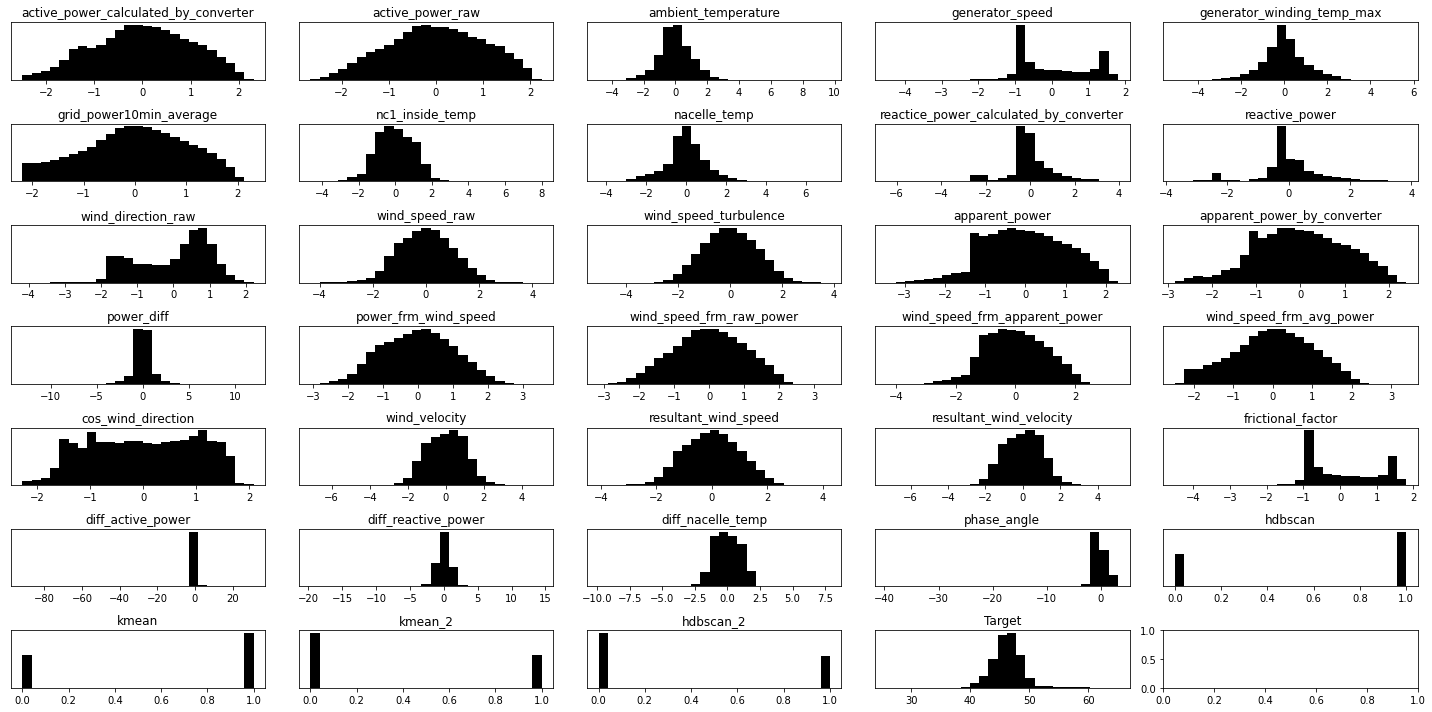

In [ ]:
# Plotting to visualize distribution of the features after skewness correction:

fig, axes = plt.subplots(7,5, figsize = (20, 10))

axes = axes.flat

for ax, column in zip(axes, num_columns):
    df[column].plot(kind = 'hist', bins = 25, color = 'black', ax= ax)
    ax.title.set_text(column)
    ax.axes.get_yaxis().set_visible(False)                                    #to remove y axis
plt.tight_layout()
plt.savefig('Skewness.png')

## Skewness in the dataset

In [ ]:
df.describe()

,active_power_calculated_by_converter,active_power_raw,ambient_temperature,generator_speed,generator_winding_temp_max,grid_power10min_average,nc1_inside_temp,nacelle_temp,reactice_power_calculated_by_converter,reactive_power,wind_direction_raw,wind_speed_raw,wind_speed_turbulence,apparent_power,apparent_power_by_converter,power_diff,power_frm_wind_speed,wind_speed_frm_raw_power,wind_speed_frm_apparent_power,wind_speed_frm_avg_power,cos_wind_direction,wind_velocity,resultant_wind_speed,resultant_wind_velocity,frictional_factor,diff_active_power,diff_reactive_power,diff_nacelle_temp,phase_angle,hdbscan,kmean,kmean_2,hdbscan_2,Target,cat___Turbine_01,cat___Turbine_10,cat___Turbine_103,cat___Turbine_105,cat___Turbine_108,cat___Turbine_120,cat___Turbine_123,cat___Turbine_13,cat___Turbine_139,cat___Turbine_14,cat___Turbine_15,cat___Turbine_158,cat___Turbine_18,cat___Turbine_19,cat___Turbine_20,cat___Turbine_97
count,906602.000000,906602.000000,906602.000000,906602.000000,906602.000000,906602.000000,906602.000000,906602.000000,906602.000000,906602.000000,906602.000000,906602.000000,906602.000000,906602.000000,906602.000000,906602.000000,906602.000000,906602.000000,906602.000000,906602.000000,906602.000000,906602.000000,906602.000000,906602.000000,906602.000000,906602.000000,906602.000000,906602.000000,906602.000000,906602.000000,906602.000000,906602.000000,906602.000000,906602.000000,906602.000000,906602.000000,906602.000000,906602.000000,906602.000000,906602.000000,906602.000000,906602.000000,906602.000000,906602.000000,906602.000000,906602.000000,906602.000000,906602.000000,906602.000000,906602.000000
mean,0.000011,0.000004,-0.000113,0.000034,-0.000004,0.000006,-0.000021,-0.000023,0.000177,-0.000011,-0.000001,0.000010,-0.000008,0.000005,0.000012,-0.000006,0.000012,0.000001,0.000002,0.000004,0.000009,0.000004,0.000010,0.000004,0.000034,-0.000049,0.000002,0.000039,0.000003,0.629593,0.625738,0.374262,0.370407,46.326658,0.059463,0.060663,0.062693,0.062877,0.062848,0.063536,0.061817,0.062396,0.062750,0.062504,0.064002,0.063363,0.063601,0.061635,0.062250,0.063605
std,0.999998,1.000002,0.998806,0.999967,1.000006,1.000003,0.999987,0.999982,0.997496,0.999889,1.000003,0.999998,0.999997,1.000001,0.999996,0.999994,0.999998,1.000001,1.000000,1.000004,0.999992,1.000000,0.999998,1.000000,0.999967,0.999820,0.998608,0.999700,0.999998,0.482914,0.483932,0.483932,0.482914,2.616442,0.236489,0.238711,0.242411,0.242741,0.242689,0.243925,0.240822,0.241873,0.242512,0.242068,0.244756,0.243615,0.244041,0.240491,0.241609,0.244047
min,-2.491579,-2.660741,-4.833633,-4.499095,-5.094453,-2.190717,-4.632671,-4.395983,-6.450723,-3.714160,-4.175711,-4.347799,-5.063383,-3.447270,-2.841518,-13.076017,-3.078484,-3.163408,-4.326029,-2.486658,-2.278192,-7.117024,-4.087171,-7.281257,-4.504764,-91.763611,-19.705021,-9.889466,-39.596399,0.000000,0.000000,0.000000,0.000000,25.865320,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-0.715301,-0.720544,-0.590616,-0.816290,-0.528016,-0.692846,-0.737485,-0.510275,-0.331230,-0.361405,-0.893134,-0.725187,-0.724867,-0.762535,-0.736651,-0.388422,-0.752748,-0.708902,-0.747953,-0.683328,-0.864756,-0.760657,-0.729484,-0.761711,-0.815963,-0.423437,-0.587884,-0.774365,-0.565967,0.000000,0.000000,0.000000,0.000000,44.816140,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.017618,0.007574,-0.041851,-0.280399,-0.040749,0.038399,-0.022142,-0.016206,-0.153908,-0.132466,0.299553,-0.002134,-0.014480,-0.030087,-0.023126,-0.005578,0.011712,0.008141,-0.029276,0.035938,0.011926,0.028029,0.004217,0.028275,-0.279961,-0.091175,-0.038459,-0.015634,-0.298089,1.000000,1.000000,0.000000,0.000000,46.300768,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.754738

In [ ]:
df_transformed = df.drop('Target', axis = 1)

In [ ]:
list(df_transformed.columns)

['active_power_calculated_by_converter',
 'active_power_raw',
 'ambient_temperature',
 'generator_speed',
 'generator_winding_temp_max',
 'grid_power10min_average',
 'nc1_inside_temp',
 'nacelle_temp',
 'reactice_power_calculated_by_converter',
 'reactive_power',
 'wind_direction_raw',
 'wind_speed_raw',
 'wind_speed_turbulence',
 'apparent_power',
 'apparent_power_by_converter',
 'power_diff',
 'power_frm_wind_speed',
 'wind_speed_frm_raw_power',
 'wind_speed_frm_apparent_power',
 'wind_speed_frm_avg_power',
 'cos_wind_direction',
 'wind_velocity',
 'resultant_wind_speed',
 'resultant_wind_velocity',
 'frictional_factor',
 'diff_active_power',
 'diff_reactive_power',
 'diff_nacelle_temp',
 'phase_angle',
 'hdbscan',
 'kmean',
 'kmean_2',
 'hdbscan_2',
 'cat___Turbine_01',
 'cat___Turbine_10',
 'cat___Turbine_103',
 'cat___Turbine_105',
 'cat___Turbine_108',
 'cat___Turbine_120',
 'cat___Turbine_123',
 'cat___Turbine_13',
 'cat___Turbine_139',
 'cat___Turbine_14',
 'cat___Turbine_15',


In [ ]:
transformed_num_columns = [column for column in list(df_transformed.columns) if column.split('__')[0] != 'cat']

In [ ]:
# Checking skewness of the columns:

df_transformed[transformed_num_columns].skew(axis = 0)

active_power_calculated_by_converter     -0.112376
active_power_raw                         -0.098819
ambient_temperature                       0.002410
generator_speed                          -0.013552
generator_winding_temp_max                0.018272
grid_power10min_average                  -0.168717
nc1_inside_temp                          -0.021626
nacelle_temp                              0.079489
reactice_power_calculated_by_converter    0.141255
reactive_power                           -0.066651
wind_direction_raw                       -0.438994
wind_speed_raw                           -0.002195
wind_speed_turbulence                     0.048690
apparent_power                           -0.045053
apparent_power_by_converter              -0.062710
power_diff                               -0.512153
power_frm_wind_speed                      0.015864
wind_speed_frm_raw_power                 -0.077327
wind_speed_frm_apparent_power            -0.028820
wind_speed_frm_avg_power       

In [ ]:
# # Correcting skewness of some columns by taking cbrt:

# import numpy as np

# # transformed_skewed_columns = transformed_num_columns

# for column in transformed_skewed_columns:
#     df_transformed[column] = np.cbrt(df_transformed[column])
#     print(column, '=> done')

In [ ]:
# # Correcting skewness of some columns by boxcox transformation:

# from scipy import stats

# transformed_skewed_columns = transformed_num_columns

# list_lambda = []
# for column in transformed_skewed_columns:
#     m, n = stats.boxcox(1 + df_transformed[column])
#     print(column, '=> done')
    
#     df_transformed[column] = pd.Series(m, index = df_transformed.index)
#     list_lambda.append(n)

In [ ]:
# # Checking skewness of the columns after transformation:

# df_transformed[transformed_num_columns].skew(axis = 0)

In [ ]:
# # Visualization of skewness correction:

# transformed_num_columns = [column for column in list(df_transformed.columns) if column.split('__')[0] != 'cat']

# fig, axes = plt.subplots(6,6, figsize = (20, 8))

# axes = axes.flat

# for ax, column in zip(axes, transformed_num_columns):
#     df_transformed[column].plot(kind = 'hist', bins = 25, color = 'black', ax= ax)
#     ax.title.set_text(column)
#     ax.axes.get_yaxis().set_visible(False)              #to remove y axis
# plt.tight_layout()

In [ ]:
# list_lambda

In [ ]:
# Check null values after skewness correction:

df_transformed.isnull().sum()

active_power_calculated_by_converter      0
active_power_raw                          0
ambient_temperature                       0
generator_speed                           0
generator_winding_temp_max                0
grid_power10min_average                   0
nc1_inside_temp                           0
nacelle_temp                              0
reactice_power_calculated_by_converter    0
reactive_power                            0
wind_direction_raw                        0
wind_speed_raw                            0
wind_speed_turbulence                     0
apparent_power                            0
apparent_power_by_converter               0
power_diff                                0
power_frm_wind_speed                      0
wind_speed_frm_raw_power                  0
wind_speed_frm_apparent_power             0
wind_speed_frm_avg_power                  0
cos_wind_direction                        0
wind_velocity                             0
resultant_wind_speed            

## Skewness in target column

In [ ]:
# df['Target'].skew()

In [ ]:
# from scipy import stats
# from scipy.special import inv_boxcox

# m, n = stats.boxcox(df['Target'])

# df['Target'] = pd.Series(m)
# target = inv_boxcox(df['Target'], n)

In [ ]:
# df['Target'].skew()

<AxesSubplot:>

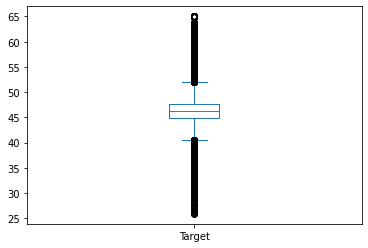

In [ ]:
df['Target'].plot(kind = 'box')

# , alpha = 0.5, bins = 50

# Modelling

<AxesSubplot:>

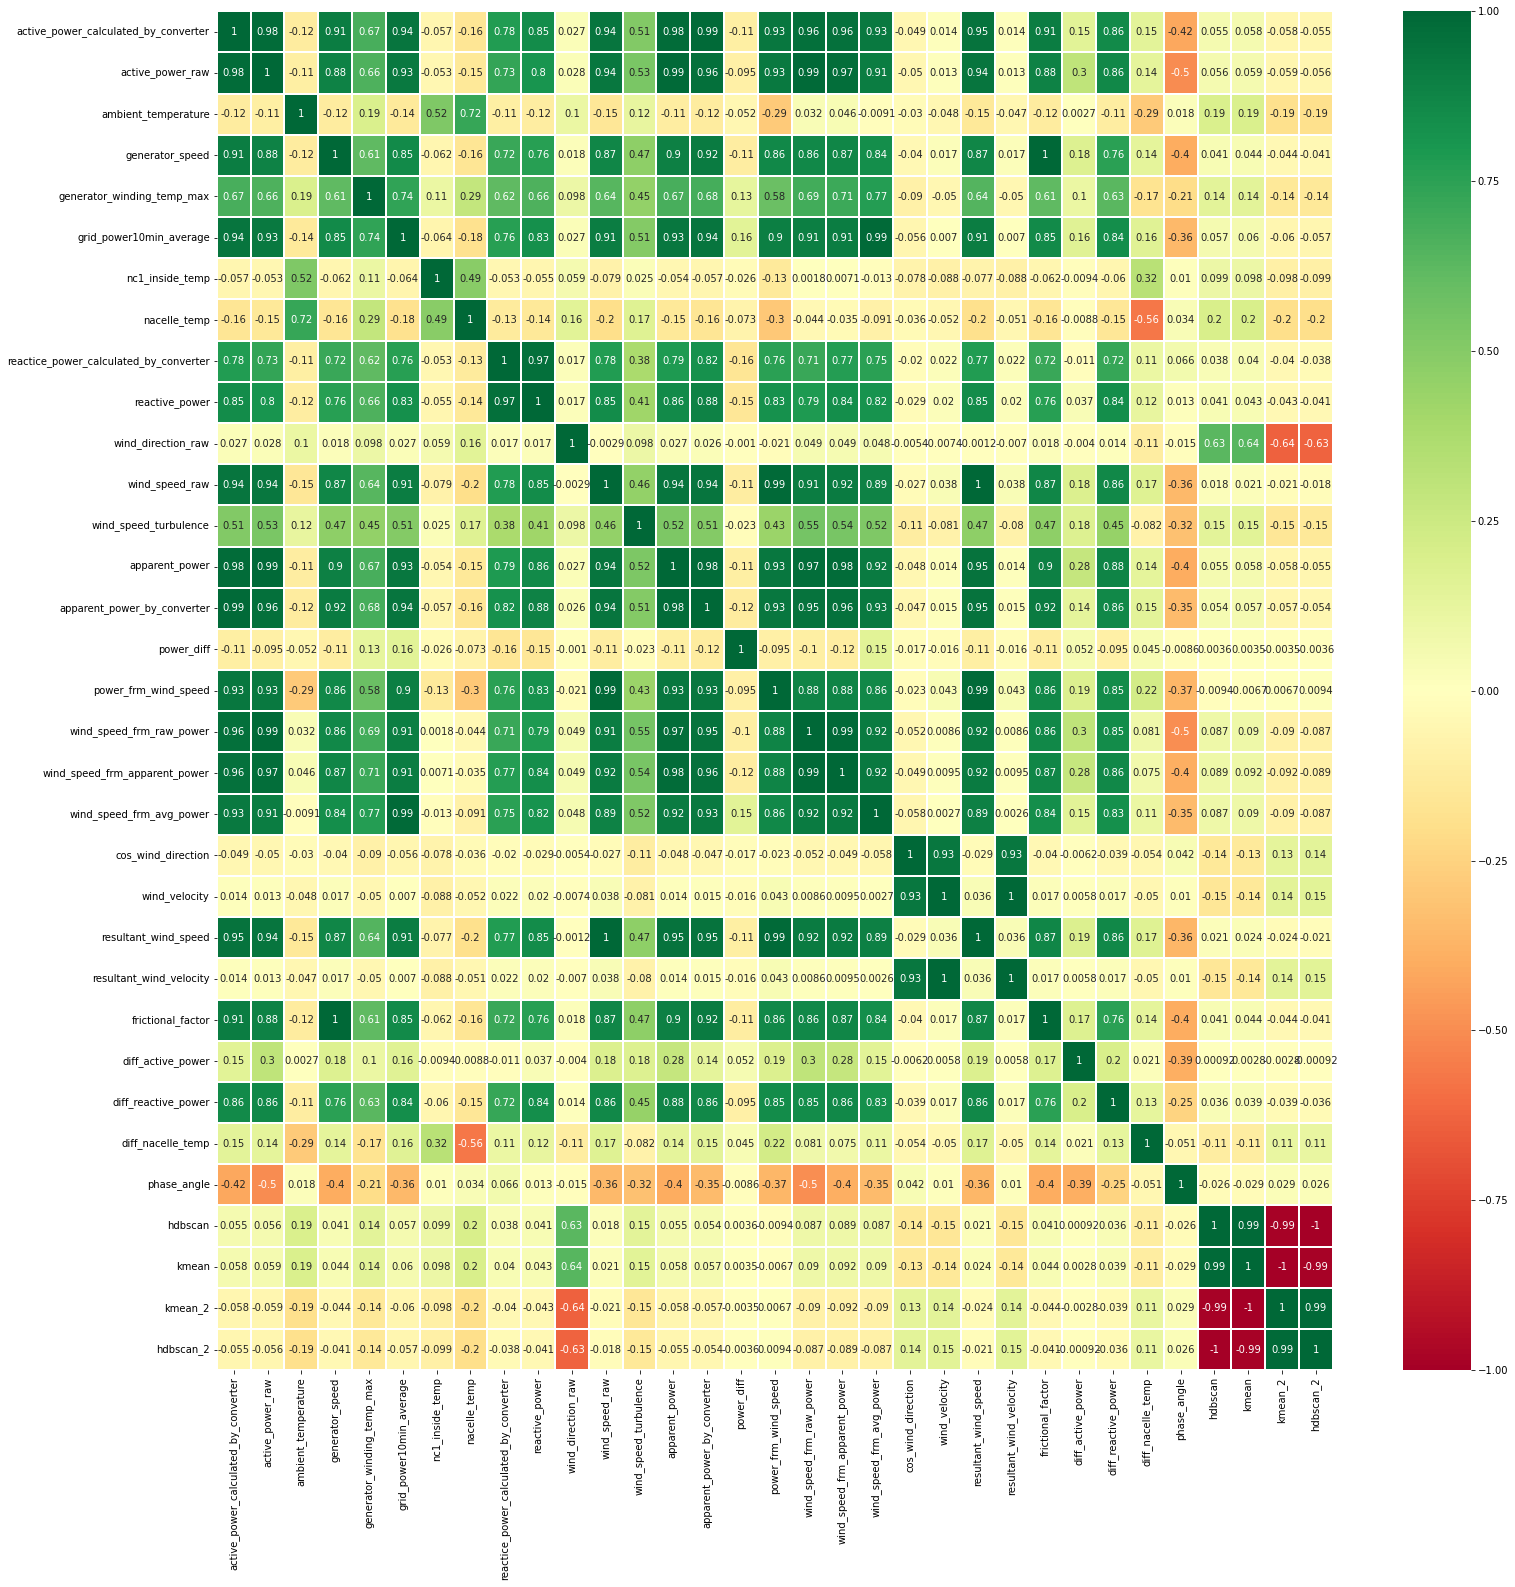

In [ ]:
# To check correlation btw. columns:

num_columns = [column for column in list(df_transformed.columns) if column.split('__')[0] != 'cat']

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize = (25, 25))
sns.heatmap(df_transformed[num_columns].corr(), cmap = 'RdYlGn', annot = True, annot_kws = {'fontsize': 10}, linewidths = 0.2)

### Notes:
> Many columns are highly correlated (> 0.9). Drop columns with multi-colinearity.

> Drop columns which doesn't impact the model by hit & trail

In [ ]:
# Print column and index:

for i, column in zip(range(0, len(df_transformed)), num_columns):
    print(column, ' ======> ', i)

active_power_calculated_by_converter  ======>  0
active_power_raw  ======>  1
ambient_temperature  ======>  2
generator_speed  ======>  3
generator_winding_temp_max  ======>  4
grid_power10min_average  ======>  5
nc1_inside_temp  ======>  6
nacelle_temp  ======>  7
reactice_power_calculated_by_converter  ======>  8
reactive_power  ======>  9
wind_direction_raw  ======>  10
wind_speed_raw  ======>  11
wind_speed_turbulence  ======>  12
apparent_power  ======>  13
apparent_power_by_converter  ======>  14
power_diff  ======>  15
power_frm_wind_speed  ======>  16
wind_speed_frm_raw_power  ======>  17
wind_speed_frm_apparent_power  ======>  18
wind_speed_frm_avg_power  ======>  19
cos_wind_direction  ======>  20
wind_velocity  ======>  21
resultant_wind_speed  ======>  22
resultant_wind_velocity  ======>  23
frictional_factor  ======>  24
diff_active_power  ======>  25
diff_reactive_power  ======>  26
diff_nacelle_temp  ======>  27
phase_angle  ======>  28
hdbscan  ======>  29
kmean  ======

In [ ]:
# Remove columns which are not necessary:

remove_index = [0, 8, 13, 14, 16, 17, 18, 19, 20, 22, 23]

selected_columns = [element for i, element in enumerate(list(df_transformed.columns)) if i not in remove_index]
selected_columns

# 0, 8, 13, 14, 15, 16, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 35

['active_power_raw',
 'ambient_temperature',
 'generator_speed',
 'generator_winding_temp_max',
 'grid_power10min_average',
 'nc1_inside_temp',
 'nacelle_temp',
 'reactive_power',
 'wind_direction_raw',
 'wind_speed_raw',
 'wind_speed_turbulence',
 'power_diff',
 'wind_velocity',
 'frictional_factor',
 'diff_active_power',
 'diff_reactive_power',
 'diff_nacelle_temp',
 'phase_angle',
 'hdbscan',
 'kmean',
 'kmean_2',
 'hdbscan_2',
 'cat___Turbine_01',
 'cat___Turbine_10',
 'cat___Turbine_103',
 'cat___Turbine_105',
 'cat___Turbine_108',
 'cat___Turbine_120',
 'cat___Turbine_123',
 'cat___Turbine_13',
 'cat___Turbine_139',
 'cat___Turbine_14',
 'cat___Turbine_15',
 'cat___Turbine_158',
 'cat___Turbine_18',
 'cat___Turbine_19',
 'cat___Turbine_20',
 'cat___Turbine_97']

In [ ]:
df_selected = df_transformed[selected_columns]

<AxesSubplot:>

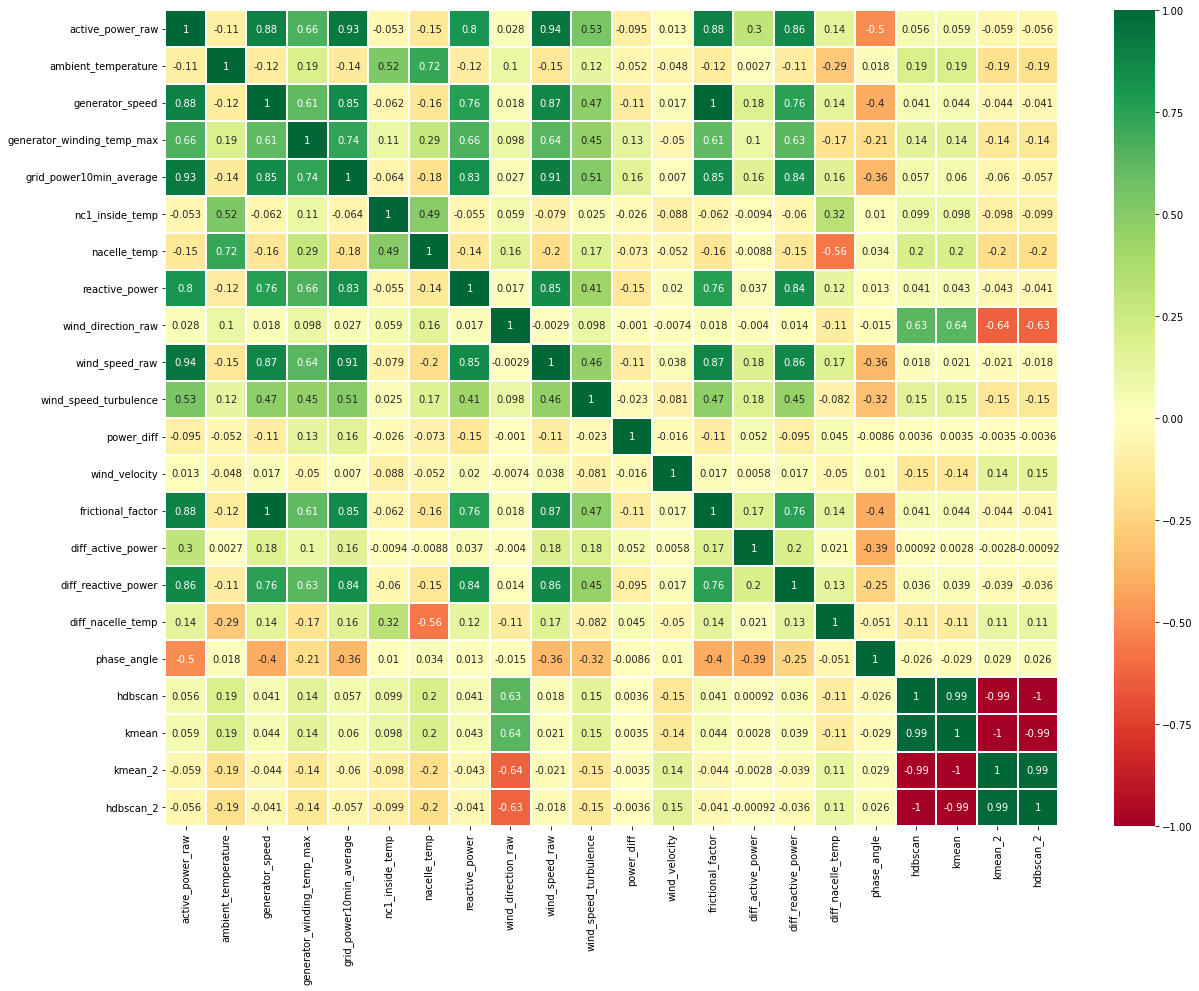

In [ ]:
# Check correlation after feature selection:

num_columns2 = [column for column in list(df_selected.columns) if column.split('__')[0] != 'cat']

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize = (20, 15))
sns.heatmap(df_selected[num_columns2].corr(), cmap = 'RdYlGn', annot = True, annot_kws = {'fontsize': 10}, linewidths = 0.2)

In [ ]:
x = df_selected
y = df['Target']

In [ ]:
(df_selected.index != turbine_id.index).sum()

0

## Uncomment below cells for dividing data into train-test

In [ ]:
# Stratified kfold split of data into train-test
# Ensure proportional split of data based on turbine groups:

# from sklearn.model_selection import StratifiedKFold

# kfold = StratifiedKFold(n_splits = 6, shuffle = True)

# for train_index, test_index in kfold.split(df_selected, turbine_id):
#     x_train, x_test = x.iloc[train_index], x.iloc[test_index]
#     y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [ ]:
# print(x_train.shape[0], x_test.shape[0])

# Other models with default parameters for comparison of score and computational time

In [ ]:
# from sklearn.linear_model import LinearRegression

# lr = LinearRegression() 
# lr.fit(x_train, y_train)

In [ ]:
# from xgboost import XGBRegressor

# xgb = XGBRegressor() 
# xgb.fit(x_train, y_train)

In [ ]:
# from lightgbm import LGBMRegressor

# lgb = LGBMRegressor() 
# lgb.fit(x_train, y_train)

In [ ]:
# from sklearn.ensemble import HistGradientBoostingRegressor

# hgb = HistGradientBoostingRegressor() 
# hgb.fit(x_train, y_train)

In [ ]:
# from sklearn.svm import SVR

# svr = SVR(kernel = 'rbf', C = 1000000, epsilon = 0.001)

# svr.fit(x_train, y_train)

In [ ]:
# from sklearn.metrics import mean_absolute_percentage_error, r2_score

# def evaluation(model):
#     train_pred = model.predict(x_train)
#     test_pred = model.predict(x_test)

#     mape_test = mean_absolute_percentage_error(y_test, test_pred)
#     mape_train = mean_absolute_percentage_error(y_train, train_pred)
#     r2_test = r2_score(y_test, test_pred)
#     r2_train = r2_score(y_test, test_pred)

#     print("mape_test: {}, mape_train: {}, r2_test: {}, r2_train: {}".format(mape_test, mape_train, r2_test, r2_train))

In [ ]:
# evaluation(lr)
# evaluation(xgb)
# evaluation(lgb)
# evaluation(hgb)

mape_test: 0.025694990180459044, mape_train: 0.025626091329405812, r2_test: 0.5679890673571661, r2_train: 0.5679890673571661
mape_test: 0.018696288522972622, mape_train: 0.018257804365156286, r2_test: 0.7564724073084285, r2_train: 0.7564724073084285


# Neural network

In [ ]:
import tensorflow.keras as tf

In [ ]:
model = tf.models.Sequential()

model.add(tf.layers.Dense(3072, activation = 'LeakyReLU', input_shape = (x.shape[1],), kernel_initializer='HeNormal'))
model.add(tf.layers.Dropout(0.2))

model.add(tf.layers.Dense(2048, activation = 'selu', kernel_initializer='LecunNormal'))
model.add(tf.layers.BatchNormalization(momentum = 0.99, epsilon = 0.001))
model.add(tf.layers.Dropout(0.2))
model.add(tf.layers.Dense(2048, activation = 'selu', kernel_initializer='LecunNormal'))
model.add(tf.layers.BatchNormalization(momentum = 0.99, epsilon = 0.001))
model.add(tf.layers.Dropout(0.2))
model.add(tf.layers.Dense(2048, activation = 'selu', kernel_initializer='LecunNormal'))
model.add(tf.layers.BatchNormalization(momentum = 0.99, epsilon = 0.001))
model.add(tf.layers.Dropout(0.2))
model.add(tf.layers.Dense(256, activation = 'selu', kernel_initializer='LecunNormal'))

model.add(tf.layers.Dense(1, activation = 'linear'))

2022-09-14 09:48:29.860454: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-14 09:48:29.865095: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-14 09:48:29.865987: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-14 09:48:29.867885: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [ ]:
data_size = x.shape[0]
epochs = 1000
batch_size = 600

steps = (data_size/batch_size)*epochs
steps

1511003.3333333333

1.6111232450556948e-06

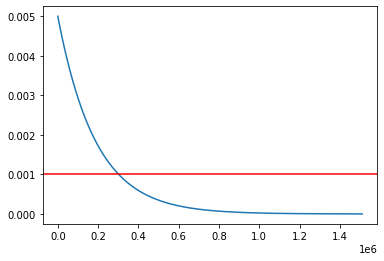

In [ ]:
# Visualizing learning rate with steps:

initial_learning_rate = 5E-3
decay_steps = steps/800
decay_rate = 0.99
staircase = True

def decayed_learning_rate(step):
    return initial_learning_rate * decay_rate ** (step / decay_steps)

lst = []
for i in range(int(steps)):
    lst.append(decayed_learning_rate(i))
    
plt.plot(lst)
plt.axhline(y = 1E-3, color = 'r', linestyle = '-')
lst[-1]

In [ ]:
from tensorflow.keras.optimizers import RMSprop, Adam, SGD

# optimizer = SGD(learning_rate = 1E-3) 

# optimizer = Adam(2E-3)

initial_learning_rate = 5E-3
lr_schedule = tf.optimizers.schedules.ExponentialDecay(initial_learning_rate,
                                                        decay_steps = steps/800,
                                                        decay_rate = 0.99,
                                                        staircase = False,
                                                      )

optimizer = Adam(learning_rate = lr_schedule)

model.compile(loss = 'MeanAbsolutePercentageError', optimizer = optimizer)

# MeanSquaredError, MeanAbsoluteError, MeanAbsolutePercentageError, MeanSquaredLogarithmicError
# , metrics = 'mean_absolute_percentage_error'
# , momentum = 0.5, nesterov = False

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 3072)              119808    
_________________________________________________________________
dropout (Dropout)            (None, 3072)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2048)              6293504   
_________________________________________________________________
batch_normalization (BatchNo (None, 2048)              8192      
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 2048)              4196352   
_________________________________________________________________
batch_normalization_1 (Batch (None, 2048)              8

In [ ]:
history = model.fit(x, y,
#                     validation_data = (x_test, y_test),
#                     validation_split = 0.2,
                    epochs = 1000,
                    batch_size = 600,
                    verbose = 1)

In [ ]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 5))

ax1.plot(history.history['loss'])
# ax1.plot(history.history['val_loss'])
ax1.legend(['train loss'], loc='upper right')

# ax2.plot(history.history['mean_absolute_percentage_error'])
# ax2.plot(history.history['val_mean_absolute_percentage_error'])
# ax2.legend(['train', 'val'], loc='lower right')

plt.show()

In [ ]:
# from sklearn.metrics import mean_absolute_percentage_error, r2_score

# test_pred = model.predict(x_test)
# mean_absolute_percentage_error(y_test, test_pred)

In [ ]:
# Save training history

import pickle

with open('./train_history_dict', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

In [ ]:
# Save model

model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

model.save_weights("model.h5")
print("Saved model to disk")

# Load saved model

In [ ]:
from tensorflow.keras.models import model_from_json

In [ ]:
json_file = open('../input/renew-power-hackathon-model/model.json', 'r')           # Provide the model.json file directory
loaded_model_json = json_file.read()
json_file.close()

loaded_model = model_from_json(loaded_model_json)

loaded_model.load_weights("../input/renew-power-hackathon-model/model.h5")        # Provide the model.h5 file directory
print("Loaded model from disk")

Loaded model from disk


In [ ]:
loaded_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 3072)              119808    
_________________________________________________________________
dropout (Dropout)            (None, 3072)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2048)              6293504   
_________________________________________________________________
batch_normalization (BatchNo (None, 2048)              8192      
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 2048)              4196352   
_________________________________________________________________
batch_normalization_1 (Batch (None, 2048)              8

In [ ]:
# from sklearn.metrics import mean_absolute_percentage_error, r2_score

# test_pred = loaded_model.predict(x_test)
# mean_absolute_percentage_error(y_test, test_pred)

# Submission file

In [ ]:
df_test = pd.read_csv('../input/renew-power-hackathon-data/test.csv')                  # Provide the test.csv file directory

df_test.head()

,active_power_calculated_by_converter,active_power_raw,ambient_temperature,generator_speed,generator_winding_temp_max,grid_power10min_average,nc1_inside_temp,nacelle_temp,reactice_power_calculated_by_converter,reactive_power,wind_direction_raw,wind_speed_raw,wind_speed_turbulence,turbine_id
0,15.507537,19.956882,40.233264,410.538834,57.357366,84.008399,48.826597,45.363477,2.419202,1.468876,156.399396,2.438629,0.790435,Turbine_14
1,472.577255,478.373881,12.306687,965.077563,51.796728,492.531362,27.457511,24.045565,96.152070,119.378235,56.443802,5.900371,0.544198,Turbine_19
2,447.829615,451.158264,29.106771,948.035899,60.493098,393.151576,39.410553,35.715697,90.251529,117.192635,224.540263,5.924923,0.513481,Turbine_14
3,254.014336,249.438965,27.074900,804.963776,55.741899,178.715101,29.476841,31.151895,89.273838,105.086257,182.151426,4.409707,0.448881,Turbine_120
4,1174.930566,1202.654077,32.148434,1199.754858,67.272313,1115.850317,31.920549,30.864276,189.731988,236.053320,261.672180,7.822326,0.561465,Turbine_158


In [ ]:
df_test.shape

(303202, 14)

In [ ]:
# Converting temp from C to K:

# df_test['ambient_temperature'] = df_test['ambient_temperature'] + 273
# df_test['nc1_inside_temp'] = df_test['nc1_inside_temp'] + 273
# df_test['nacelle_temp'] = df_test['nacelle_temp'] + 273

# Powers:

df_test['apparent_power'] = (df_test['active_power_raw']**2 + df_test['reactive_power']**2)**0.5
# df_test['power_factor'] = df_test['active_power_raw']/df_test['apparent_power']

df_test['apparent_power_by_converter'] = (df_test['active_power_calculated_by_converter']**2 + df_test['reactice_power_calculated_by_converter']**2)**0.5
# df_test['power_factor_by_converter'] = df_test['active_power_calculated_by_converter']/df_test['apparent_power_by_converter']

df_test['power_diff'] =  df_test['grid_power10min_average'] - df_test['apparent_power_by_converter']

# df_test['power_sum'] = df_test['active_power_raw'] + df_test['reactive_power']
# df_test['power_sum_by_converter'] = df_test['active_power_calculated_by_converter'] + df_test['reactice_power_calculated_by_converter']

df_test['power_frm_wind_speed'] = (df_test['wind_speed_raw']**3)/df_test['ambient_temperature']                       #Generate power directly proportional to v**3

# Wind speed:

df_test['wind_speed_frm_raw_power'] = (df_test['ambient_temperature'] * df_test['active_power_raw'])**(1/3)
df_test['wind_speed_frm_apparent_power'] = (df_test['ambient_temperature'] * df_test['apparent_power'])**(1/3)
df_test['wind_speed_frm_avg_power'] = (df_test['ambient_temperature'] * df_test['grid_power10min_average'])**(1/3)

# df_test['wind_speed_frm_power_sum'] = (df_test['ambient_temperature'] * df_test['power_sum'])**(1/3)
# df_test['wind_speed_frm_power_sum_by_converter'] = (df_test['ambient_temperature'] * df_test['power_sum_by_converter'])**(1/3)

import numpy as np

df_test['cos_wind_direction'] = np.cos(np.radians(df_test['wind_direction_raw']))
df_test['wind_velocity'] = df_test['wind_speed_raw'] * df_test['cos_wind_direction']

df_test['resultant_wind_speed'] = (df_test['wind_speed_raw']**2 + df_test['wind_speed_turbulence']**2)**0.5
df_test['resultant_wind_velocity'] = df_test['resultant_wind_speed'] * df_test['cos_wind_direction']

df_test['frictional_factor'] = df_test['generator_speed']**2                                                         #Frictional force directly proportional to omega**2

df_test['diff_active_power'] = df_test['active_power_raw'] - df_test['active_power_calculated_by_converter']         #Difference btw. input & output of convertor
df_test['diff_reactive_power'] = df_test['reactive_power'] - df_test['reactice_power_calculated_by_converter']       #Difference btw. input & output of convertor
df_test['diff_nacelle_temp'] = df_test['nc1_inside_temp'] - df_test['nacelle_temp']                                  #Difference between inside and outside nacelle temp

# Phase angle between active and reactive power:

df_test['phase_angle'] = np.arctan(df_test['reactive_power']/df_test['active_power_raw'])
# df_test['phase_angle_by_converter'] = np.arctan(df_test['reactice_power_calculated_by_converter']/df_test['active_power_calculated_by_converter'])

In [ ]:
dict_turbine_x_test = {}

for turbine_id, data in df_test.groupby('turbine_id'):
    
    data = data.drop(['turbine_id'], axis =1)
    dict_turbine_x_test[turbine_id] = data

In [ ]:
# All turbine's name as keys:

dict_turbine_x_test.keys()

dict_keys(['Turbine_01', 'Turbine_10', 'Turbine_103', 'Turbine_105', 'Turbine_108', 'Turbine_120', 'Turbine_123', 'Turbine_13', 'Turbine_139', 'Turbine_14', 'Turbine_15', 'Turbine_158', 'Turbine_18', 'Turbine_19', 'Turbine_20', 'Turbine_97'])

In [ ]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from cuml.manifold import TSNE
from sklearn.cluster import KMeans
from hdbscan import flat
from hdbscan.flat import (HDBSCAN_flat,
                          approximate_predict_flat,
                          membership_vector_flat,
                          all_points_membership_vectors_flat)
import matplotlib.pyplot as plt

dict_scaler_minmax2 = {}

for key in dict_turbine_x_test.keys():
    
#     Select features to be used for clustering:
    df2 = dict_turbine_x_test[key]
    df2 = df2[['ambient_temperature', 'wind_direction_raw', 'wind_speed_turbulence', 'wind_speed_raw']]
    
#     Scaling before clustering:
    dict_scaler_minmax2[key] = MinMaxScaler()
    df2 = pd.DataFrame(dict_scaler_minmax2[key].fit_transform(df2), columns = df2.columns, index = df2.index)
    
#     KMean clusttering:
    pred_km = dict_kmean[key].predict(df2)
    
#     HBDSCAN clusterring:
    try:
        labels, proba = approximate_predict_flat(dict_hbds[key], df2, n_clusters = 2)
        pred_hbds = labels
    except:
        print('HDBSCAN failed for -->', key)
#         If HDBSCAN fails to form two clusters then use Kmean
        pred_hbds = pred_km
    
#     Save labels
    dict_turbine_x_test[key]['hdbscan'] = pred_hbds
    dict_turbine_x_test[key]['kmean'] = pred_km
    
# #     Uncomment below to visualize clusttering:
    
# #     t-SNE plot:
#     tsne = TSNE(random_state = 6, 
#                 n_components = 2, perplexity = 30, 
#                 early_exaggeration = 25, late_exaggeration = 15, 
#                 learning_rate = 50, n_iter = 2000, 
#                 method = 'barnes_hut', exaggeration_iter = 250)
#     df_tsne = tsne.fit_transform(df2)
    
# #     Plotting Clusttering results:
#     fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (20, 5))
#     fig.suptitle(key)
    
#     ax1.scatter(df_tsne[:,0], df_tsne[:,1], s = 0.5, label = 't-SNE')
#     ax2.scatter(df_tsne[:,0], df_tsne[:,1], c = pred_km, s = 0.5, label = 'Kmean')
#     ax3.scatter(df_tsne[:,0], df_tsne[:,1], c = pred_hbds, s = 0.5, label = 'HBDSCAN')
    
#     ax1.legend()
#     ax2.legend()
#     ax3.legend()
    
#     plt.show()

HDBSCAN failed for --> Turbine_108
HDBSCAN failed for --> Turbine_20


In [ ]:
# To set label 1 for hot season and label 0 for other seasons: 

for key in dict_turbine_x_test.keys():
    if dict_turbine_x_test[key].groupby(['hdbscan'])['ambient_temperature'].agg(mean = 'mean')[-2:].sort_values(by = 'mean').index[0] == 1:
        dict_turbine_x_test[key]['hdbscan'] = np.where(dict_turbine_x_test[key]['hdbscan'] == -1, dict_turbine_x_test[key]['hdbscan'], 1 - dict_turbine_x_test[key]['hdbscan'])

# To impute the noise labels (-1) in hdbscan with kmean labels: 

for key in dict_turbine_x_test.keys():
    
    m = dict_turbine_x_test[key].groupby(['hdbscan'])['ambient_temperature'].agg(mean = 'mean')[-2:].sort_values(by = 'mean').index
    n = dict_turbine_x_test[key].groupby(['kmean'])['ambient_temperature'].agg(mean = 'mean').sort_values(by = 'mean').index
    
    if sum(m*n) == 0:
        dict_turbine_x_test[key]['kmean'] = 1 - dict_turbine_x_test[key]['kmean']
        
    dict_turbine_x_test[key]['hdbscan'] = np.where(dict_turbine_x_test[key]['hdbscan'] == -1, dict_turbine_x_test[key]['kmean'], dict_turbine_x_test[key]['hdbscan'])

# To have two OHE columns for both labels:

for key in dict_turbine_x_test.keys():
    dict_turbine_x_test[key]['kmean_2'] = 1 - dict_turbine_x_test[key]['kmean']
    dict_turbine_x_test[key]['hdbscan_2'] = 1 - dict_turbine_x_test[key]['hdbscan']

In [ ]:
# Seperate scaling each turbine with scaler from train df:

for key in dict_turbine_x_test.keys():
    columns = list(dict_turbine_x_test[key].columns)[:-4]
    dict_turbine_x_test[key][columns] = pd.DataFrame(dict_scaler_powertrans[key].transform(dict_turbine_x_test[key][columns]), columns = columns, index = dict_turbine_x_test[key][columns].index)

In [ ]:
# Concatenating all into single df:

df_test = pd.DataFrame()
for key in dict_turbine_x_test.keys():
    dict_turbine_x_test[key]['turbine_id'] = key
    df_test = pd.concat([df_test, dict_turbine_x_test[key]], axis = 0)

In [ ]:
# One Hot Encode categorical 'turbine_id' feature:

df_test = pd.get_dummies(df_test, columns = ['turbine_id'], prefix = 'cat__')

df_test.head()

,active_power_calculated_by_converter,active_power_raw,ambient_temperature,generator_speed,generator_winding_temp_max,grid_power10min_average,nc1_inside_temp,nacelle_temp,reactice_power_calculated_by_converter,reactive_power,wind_direction_raw,wind_speed_raw,wind_speed_turbulence,apparent_power,apparent_power_by_converter,power_diff,power_frm_wind_speed,wind_speed_frm_raw_power,wind_speed_frm_apparent_power,wind_speed_frm_avg_power,cos_wind_direction,wind_velocity,resultant_wind_speed,resultant_wind_velocity,frictional_factor,diff_active_power,diff_reactive_power,diff_nacelle_temp,phase_angle,hdbscan,kmean,kmean_2,hdbscan_2,cat___Turbine_01,cat___Turbine_10,cat___Turbine_103,cat___Turbine_105,cat___Turbine_108,cat___Turbine_120,cat___Turbine_123,cat___Turbine_13,cat___Turbine_139,cat___Turbine_14,cat___Turbine_15,cat___Turbine_158,cat___Turbine_18,cat___Turbine_19,cat___Turbine_20,cat___Turbine_97
15,0.323049,0.309711,1.046695,0.106294,1.327270,-0.004004,-1.387051,1.079542,0.544769,0.536385,-0.849902,0.274863,-0.414178,0.308744,0.312178,-0.867791,0.169076,0.410958,0.419959,0.089432,-1.170059,-1.096733,0.271731,-1.094692,0.106553,-0.190495,0.451456,-1.650777,0.215317,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
56,-1.130140,-1.235747,0.274807,-1.216185,-1.441285,-1.688637,-1.242656,0.245051,-1.659439,-1.946062,-0.694583,-1.655557,-0.508217,-1.424635,-1.248376,-0.286266,-1.671163,-1.197149,-1.387816,-1.659692,-1.364912,-1.034266,-1.688041,-1.035459,-1.216268,-0.516658,-2.053351,-0.874852,-1.531773,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
73,-0.662503,-0.742636,-0.783574,-0.794353,-0.635243,-0.311194,1.531014,-0.873111,0.525267,0.366760,-0.737244,-0.646879,-0.117620,-0.593956,-0.545746,0.313868,-0.615773,-0.773633,-0.633100,-0.346510,-1.318499,-1.134252,-0.649383,-1.134116,-0.794212,-0.616035,-0.541394,1.330235,1.652993,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
106,0.670050,0.681200,-0.048418,0.726937,-0.279080,0.059842,0.487378,-0.022379,0.063394,0.122705,0.887697,0.550162,1.575772,0.659372,0.646364,-1.792225,0.552092,0.690339,0.671891,0.077122,0.650617,0.744015,0.594132,0.760018,0.727030,0.227043,0.392838,0.231966,-0.585395,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
110,-0.235032,-0.268834,-0.015003,-0.607920,-1.938642,-1.721746,1.591904,-0.008619,-0.723181,-0.701382,-0.588299,-0.357644,0.801452,-0.349785,-0.301635,-1.477343,-0.400867,-0.245384,-0.321575,-1.701557,-1.459094,-1.347190,-0.331849,-1.351165,-0.607716,-0.384620,-0.490979,0.630478,-0.494100,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Print column and index:

num_columns = [column for column in list(df_test.columns) if column.split('__')[0] != 'cat']

for i, column in zip(range(0, len(df_test)), num_columns):
    print(column, ' ======> ', i)

active_power_calculated_by_converter  ======>  0
active_power_raw  ======>  1
ambient_temperature  ======>  2
generator_speed  ======>  3
generator_winding_temp_max  ======>  4
grid_power10min_average  ======>  5
nc1_inside_temp  ======>  6
nacelle_temp  ======>  7
reactice_power_calculated_by_converter  ======>  8
reactive_power  ======>  9
wind_direction_raw  ======>  10
wind_speed_raw  ======>  11
wind_speed_turbulence  ======>  12
apparent_power  ======>  13
apparent_power_by_converter  ======>  14
power_diff  ======>  15
power_frm_wind_speed  ======>  16
wind_speed_frm_raw_power  ======>  17
wind_speed_frm_apparent_power  ======>  18
wind_speed_frm_avg_power  ======>  19
cos_wind_direction  ======>  20
wind_velocity  ======>  21
resultant_wind_speed  ======>  22
resultant_wind_velocity  ======>  23
frictional_factor  ======>  24
diff_active_power  ======>  25
diff_reactive_power  ======>  26
diff_nacelle_temp  ======>  27
phase_angle  ======>  28
hdbscan  ======>  29
kmean  ======

In [ ]:
# Remove columns which are not necessary (present in train df):

remove_index = [0, 8, 13, 14, 16, 17, 18, 19, 20, 22, 23]

selected_columns = [element for i, element in enumerate(list(df_transformed.columns)) if i not in remove_index]
selected_columns

# 0, 1, 8, 9, 10, 15, 16, 18, 19, 21, 22, 23, 24, 25, 27, 28, 29, 33

['active_power_raw',
 'ambient_temperature',
 'generator_speed',
 'generator_winding_temp_max',
 'grid_power10min_average',
 'nc1_inside_temp',
 'nacelle_temp',
 'reactive_power',
 'wind_direction_raw',
 'wind_speed_raw',
 'wind_speed_turbulence',
 'power_diff',
 'wind_velocity',
 'frictional_factor',
 'diff_active_power',
 'diff_reactive_power',
 'diff_nacelle_temp',
 'phase_angle',
 'hdbscan',
 'kmean',
 'kmean_2',
 'hdbscan_2',
 'cat___Turbine_01',
 'cat___Turbine_10',
 'cat___Turbine_103',
 'cat___Turbine_105',
 'cat___Turbine_108',
 'cat___Turbine_120',
 'cat___Turbine_123',
 'cat___Turbine_13',
 'cat___Turbine_139',
 'cat___Turbine_14',
 'cat___Turbine_15',
 'cat___Turbine_158',
 'cat___Turbine_18',
 'cat___Turbine_19',
 'cat___Turbine_20',
 'cat___Turbine_97']

In [ ]:
df_selected = df_test[selected_columns]

In [ ]:
# Check for null values:

df_selected.isna().sum()

active_power_raw              0
ambient_temperature           0
generator_speed               0
generator_winding_temp_max    0
grid_power10min_average       0
nc1_inside_temp               0
nacelle_temp                  0
reactive_power                0
wind_direction_raw            0
wind_speed_raw                0
wind_speed_turbulence         0
power_diff                    0
wind_velocity                 0
frictional_factor             0
diff_active_power             0
diff_reactive_power           0
diff_nacelle_temp             0
phase_angle                   0
hdbscan                       0
kmean                         0
kmean_2                       0
hdbscan_2                     0
cat___Turbine_01              0
cat___Turbine_10              0
cat___Turbine_103             0
cat___Turbine_105             0
cat___Turbine_108             0
cat___Turbine_120             0
cat___Turbine_123             0
cat___Turbine_13              0
cat___Turbine_139             0
cat___Tu

In [ ]:
df_selected = df_selected.sort_index()

df_selected.head()

,active_power_raw,ambient_temperature,generator_speed,generator_winding_temp_max,grid_power10min_average,nc1_inside_temp,nacelle_temp,reactive_power,wind_direction_raw,wind_speed_raw,wind_speed_turbulence,power_diff,wind_velocity,frictional_factor,diff_active_power,diff_reactive_power,diff_nacelle_temp,phase_angle,hdbscan,kmean,kmean_2,hdbscan_2,cat___Turbine_01,cat___Turbine_10,cat___Turbine_103,cat___Turbine_105,cat___Turbine_108,cat___Turbine_120,cat___Turbine_123,cat___Turbine_13,cat___Turbine_139,cat___Turbine_14,cat___Turbine_15,cat___Turbine_158,cat___Turbine_18,cat___Turbine_19,cat___Turbine_20,cat___Turbine_97
0,-1.794954,2.357914,-2.585666,0.112019,-1.020971,2.467279,2.510761,-2.301968,-0.600653,-2.518863,0.671635,0.573564,0.017896,-2.588772,-0.097718,-1.740103,0.046075,-1.490554,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,0.305535,-2.056297,0.183356,-1.230359,0.340121,-1.980773,-2.001610,-0.024717,-1.551213,0.082941,-0.181265,0.220622,0.965918,0.183746,-0.017300,0.382913,-0.067904,-0.353228,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,0.144289,0.341701,-0.000989,0.432756,0.025177,0.516095,0.466452,-0.129800,0.206403,0.077343,-0.416781,-0.298249,-0.431371,-0.000520,-0.138157,0.355341,0.421727,-0.258065,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,-0.335350,-0.210136,-0.696900,-0.465042,-0.541142,-0.984528,-0.345798,-0.238612,-0.447666,-0.651444,-0.605282,-0.476141,-1.913388,-0.696589,-0.394155,-0.247708,-0.570236,0.368117,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,1.211528,-0.057730,1.335299,0.983347,1.113341,-0.095783,-0.163203,1.096702,0.498768,0.871934,0.013595,-0.457977,-0.680151,1.334579,0.355088,1.118664,0.062451,-0.279990,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [ ]:
# Prediction:

df_test_pred = loaded_model.predict(df_selected)
df_test_pred = pd.DataFrame(df_test_pred)

2022-09-14 09:49:00.911097: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [ ]:
df_test_pred.columns = ['Target']
df_test_pred[df_test_pred['Target'] < 0] = df_test_pred['Target'].mean()

df_test_pred.to_csv("Submission.csv", index = False)

In [ ]:
df_test_pred.head()

,Target
0,49.493389
1,40.944096
2,48.134808
3,45.651188
4,45.394543


<AxesSubplot:>

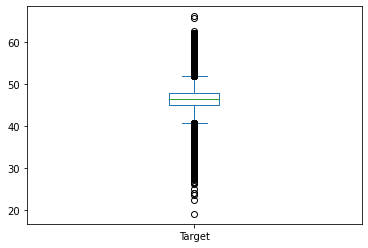

In [ ]:
df_test_pred.plot(kind = 'box')

In [ ]:
df_test_pred.skew()

Target    0.637995
dtype: float32

In [ ]:
df_test_pred.isna().sum()

Target    0
dtype: int64

In [ ]:
df_test_pred.shape

(303202, 1)

### Inferences / Improvement prospects:
* Clustering of data (most likely seasonal) had significant impact on the model improvement   
* Increasing perceptron/neurons in the first layer improves the optimization
  > Increasing the neural network capability of extracting low level features in the front layers  
* Local anomaly/outlier removal can be tried 
* Training neural network takes approx. 7 hrs. Tuning of epoch, batch_size and learning rate can decrease computational time